In [ ]:
# =============================
# STEP 0 — Setup & Load
# =============================
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

sns.set(style="whitegrid")

FIG_DIR = "../figurez/global"
OUT_DIR = "../tables"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

# --- carica split definitivi
train = pd.read_csv("../data/processed/train_balanced_ctgan.csv")
test  = pd.read_csv("../data/processed/test_original.csv")

y_train = train["target_bin"].astype(int).values
y_test  = test["target_bin"].astype(int).values

# Ordine fisso delle feature (quelle del tuo dataset core+covariate)
feature_order = [
    "MSE ML","iHR V","MSE V","MSE AP","Weigth",
    "Age","Sex (M=1, F=2)","H-Y","Gait Speed","Duration (years)"
]
X_train = train[feature_order].copy()
X_test  = test[feature_order].copy()

print(f"Train: {X_train.shape}  |  Test: {X_test.shape}")

# =============================
# STEP 1 — Fit modello finale (Random Forest balanced)
# =============================
rf = RandomForestClassifier(
    n_estimators=800,
    max_depth=None,
    min_samples_leaf=3,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Metriche sul test reale
p_test = rf.predict_proba(X_test)[:, 1]
metrics = {
    "ROC_AUC_test": round(roc_auc_score(y_test, p_test), 3),
    "PR_AUC_test": round(average_precision_score(y_test, p_test), 3),
    "Brier_test": round(brier_score_loss(y_test, p_test), 3)
}
print(metrics)

Train: (262, 10)  |  Test: (55, 10)
{'ROC_AUC_test': 0.731, 'PR_AUC_test': 0.733, 'Brier_test': 0.198}


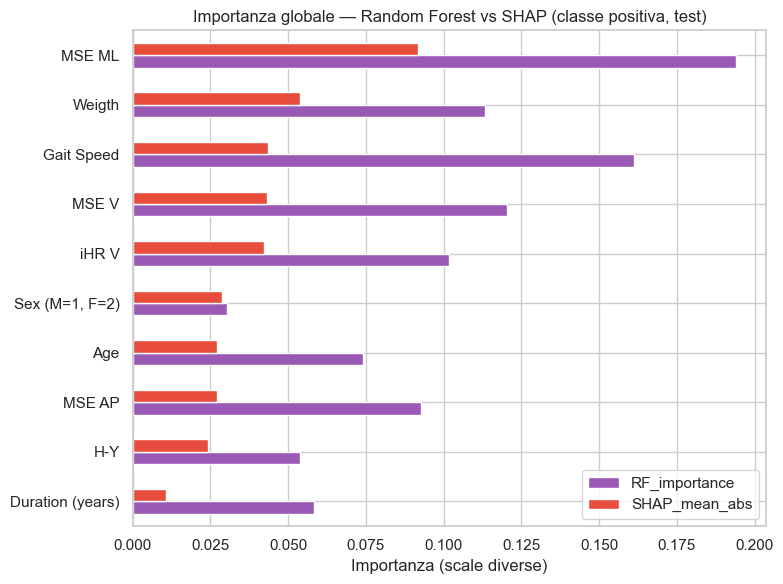

✅ Salvati: figura e tabella importanze globali (RF vs SHAP).


In [5]:
# =============================
# 2) RF Importance vs SHAP (global) — FIX per shape (n,feat,classes)
# =============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

sns.set(style="whitegrid")

# --- 2.1 RF feature importances
rf_imp = pd.Series(rf.feature_importances_, index=feature_order, name="RF_importance")
rf_imp = rf_imp.sort_values(ascending=False)

# --- 2.2 SHAP values
explainer = shap.TreeExplainer(rf, data=X_train, feature_names=feature_order)
shap_expl = explainer(X_test)      # shap.Explanation
shap_vals = shap_expl.values       # può essere (n, feat) oppure (n, feat, classes)

# Se binario con 3D, prendi la classe positiva (indice 1)
if shap_vals.ndim == 3:
    shap_vals_pos = shap_vals[:, :, 1]
    base_vals_pos = np.array(shap_expl.base_values)[:, 1]
    shap_expl_pos = shap.Explanation(
        values=shap_vals_pos,
        base_values=base_vals_pos,
        data=shap_expl.data,
        feature_names=feature_order
    )
else:
    shap_vals_pos = shap_vals
    shap_expl_pos = shap_expl  # già 2D

# mean |SHAP| per feature (importanza globale)
shap_imp = pd.Series(np.abs(shap_vals_pos).mean(axis=0), index=feature_order, name="SHAP_mean_abs")
shap_imp = shap_imp.sort_values(ascending=False)

# --- 2.3 Confronto side-by-side (barh)
cmp = (
    pd.concat([rf_imp, shap_imp], axis=1)
      .reindex(shap_imp.index)  # ordina per SHAP
)

plt.figure(figsize=(8, 6))
cmp.iloc[::-1].plot(kind="barh", ax=plt.gca(), color=["#9b59b6", "#e74c3c"])
plt.title("Importanza globale — Random Forest vs SHAP (classe positiva, test)")
plt.xlabel("Importanza (scale diverse)")
plt.ylabel("")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/explain_global_rf_vs_shap.png", dpi=300)
plt.show()

# --- 2.4 Salva tabella importanze
cmp.to_csv(f"{FIG_DIR}/explain_global_rf_vs_shap_table.csv", index=True)
print("✅ Salvati: figura e tabella importanze globali (RF vs SHAP).")

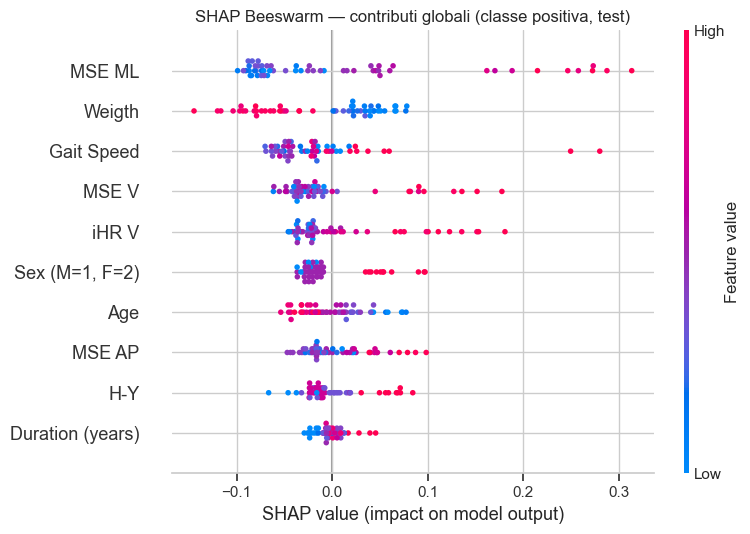

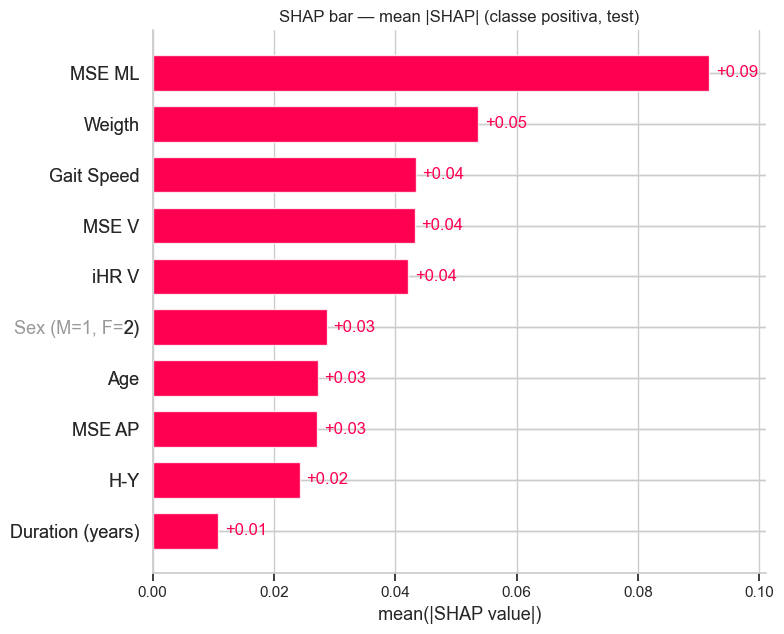

In [7]:
# =============================
# 3) SHAP Summary (beeswarm & bar) — robusto per multi-output
# =============================
import numpy as np
import matplotlib.pyplot as plt
import shap

# -- se shap_expl è già calcolato nello step 2, usiamo quello.
#    altrimenti, per sicurezza:
# shap_expl = explainer(X_test, check_additivity=False)

def _to_positive_class_expl(expl, feature_names):
    """
    Rende l'Explanation 2D (n_samples, n_features) per la classe positiva.
    Funziona sia se expl.values è 2D che 3D (multi-output).
    """
    vals = expl.values
    base = expl.base_values
    data = expl.data

    if vals.ndim == 3:
        # (n_samples, n_features, n_classes) -> teniamo classe 1
        vals_pos = vals[:, :, 1]
        base_pos = base[:, 1] if base.ndim == 2 else base
        return shap.Explanation(values=vals_pos,
                                base_values=base_pos,
                                data=data,
                                feature_names=feature_names)
    elif vals.ndim == 2:
        return expl
    else:
        raise ValueError(f"Shape SHAP inattesa: {vals.shape}")

# --- 3.1 Seleziona classe positiva
shap_expl_pos = _to_positive_class_expl(shap_expl, feature_order)

# --- 3.2 Beeswarm
plt.figure(figsize=(9, 6))
shap.plots.beeswarm(shap_expl_pos, max_display=10, show=False)
plt.title("SHAP Beeswarm — contributi globali (classe positiva, test)")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/explain_shap_beeswarm.png", dpi=300)
plt.show()

# --- 3.3 Bar plot |SHAP| medio
plt.figure(figsize=(8, 6))
shap.plots.bar(shap_expl_pos, max_display=10, show=False)
plt.title("SHAP bar — mean |SHAP| (classe positiva, test)")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/explain_shap_bar.png", dpi=300)
plt.show()

Top-3 feature (per dependence): ['MSE ML', 'Weigth', 'Gait Speed']


<Figure size 700x500 with 0 Axes>

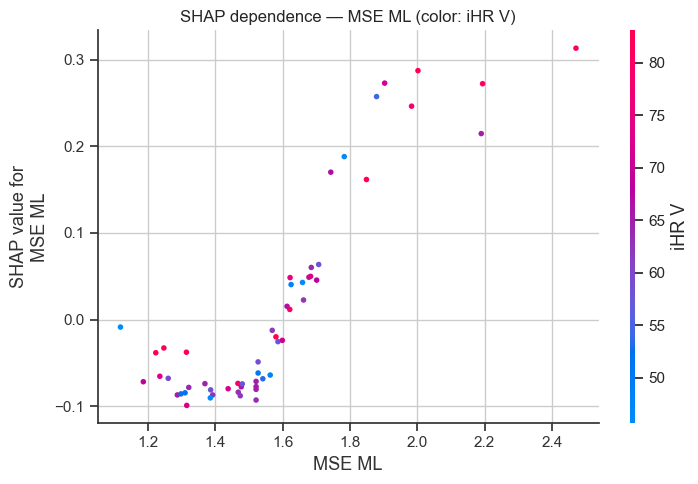

✅ Salvato: ../figures/explain_dependence_MSE_ML.png


<Figure size 700x500 with 0 Axes>

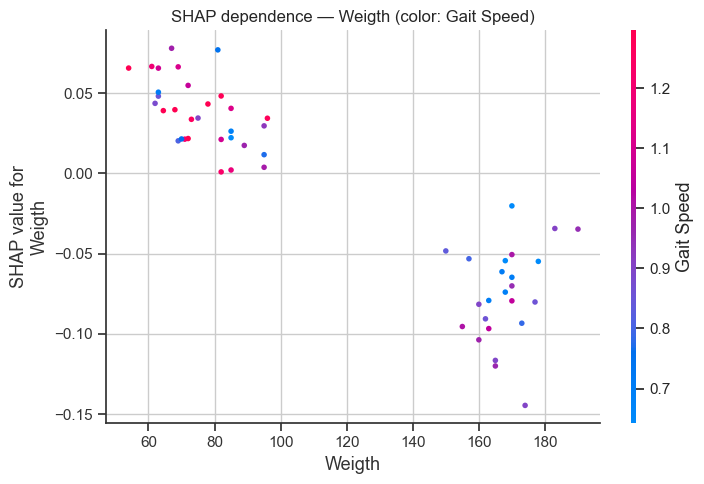

✅ Salvato: ../figures/explain_dependence_Weigth.png


<Figure size 700x500 with 0 Axes>

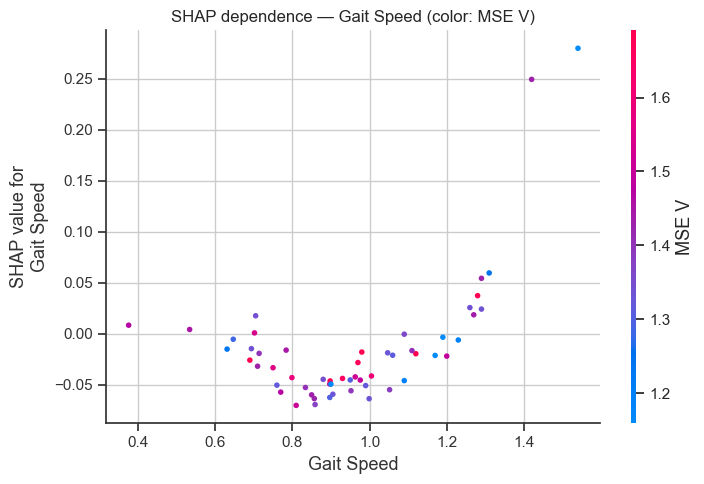

✅ Salvato: ../figures/explain_dependence_Gait_Speed.png


In [9]:
# =============================
# 4) SHAP Dependence con interazione (robusto, legacy API)
# =============================
import matplotlib.pyplot as plt
import shap

# 4.1 Estrai i valori SHAP della classe positiva in forma (n_test, n_features)
# (compatibile con Explainer moderno e vecchio)
if hasattr(shap_expl, "values"):
    sval = shap_expl.values
else:
    sval = shap_expl  # fallback

# Se sono 3D (n, n_feat, 2 classi), prendi la colonna della classe 1
if sval.ndim == 3 and sval.shape[-1] == 2:
    shap_vals_pos = sval[:, :, 1]
elif sval.ndim == 2:
    shap_vals_pos = sval
else:
    raise ValueError(f"Formato SHAP inatteso: shape={sval.shape}")

# 4.2 Top-3 feature globali (già calcolate nello step 2 come 'shap_imp')
top3 = shap_imp.index[:3].tolist()
print("Top-3 feature (per dependence):", top3)

# 4.3 Definisci partner d’interazione (colore)
inter_partner = {
    "MSE ML": "iHR V",        # biomeccanica: entropia mediolaterale × variabilità verticale
    "Weigth": "Gait Speed",   # antropometria × velocità
    "Gait Speed": "MSE V"     # dinamica del passo × entropia verticale
}

# 4.4 Disegna e salva
for feat in top3:
    partner = inter_partner.get(feat, None)

    plt.figure(figsize=(7, 5))
    # NB: dependence_plot (legacy) accetta il nome colonna + matrice shap + X (DF)
    shap.dependence_plot(
        ind=feat,
        shap_values=shap_vals_pos,
        features=X_test,
        interaction_index=partner,
        show=False  # così controlliamo noi il salvataggio
    )
    title = f"SHAP dependence — {feat}" + (f" (color: {partner})" if partner else "")
    plt.title(title)
    plt.tight_layout()
    out_path = f"{FIG_DIR}/explain_dependence_{feat.replace(' ', '_')}.png"
    plt.savefig(out_path, dpi=300)
    plt.show()
    print(f"✅ Salvato: {out_path}")

✅ Salvata tabella H² coppie: ../data/processed/friedman_H_pairs_test.csv
           feat_A          feat_B        H2
0  Sex (M=1, F=2)      Gait Speed  0.042027
1          MSE ML           MSE V  0.024533
2          MSE ML          MSE AP  0.022588
3          MSE ML           iHR V  0.019505
4           MSE V          Weigth  0.011160
5          MSE ML  Sex (M=1, F=2)  0.010644
6          MSE ML          Weigth  0.005611
7          MSE ML      Gait Speed  0.005203
8          MSE ML             H-Y  0.004845
9           iHR V           MSE V  0.004331


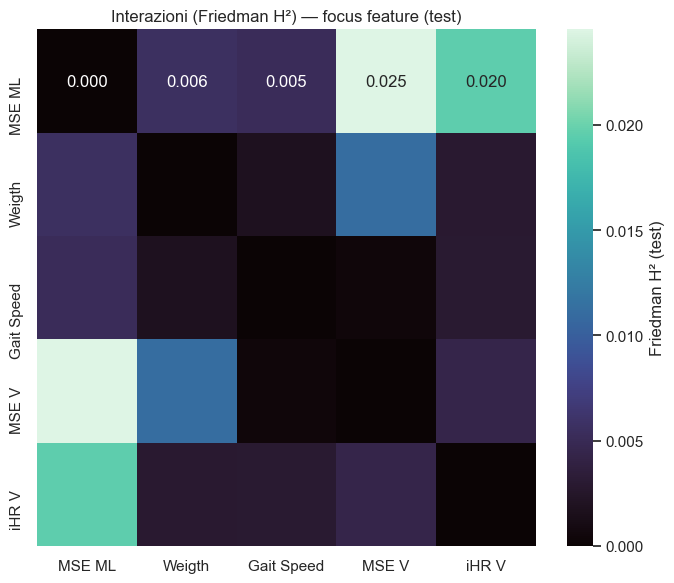

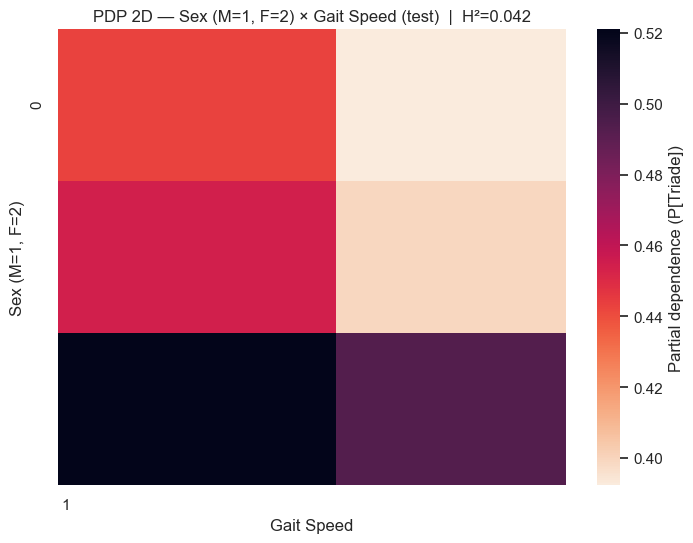

In [17]:
# =============================
# 5) Interazioni robuste — Friedman H² + PDP 2D
# =============================
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from itertools import combinations
from sklearn.inspection import partial_dependence

# --- mapping nome -> indice (evita errori con tuple di nomi)
_col_idx = {c: i for i, c in enumerate(X_test.columns)}

def _norm_pd1d(pdp_obj):
    """Normalizza l'output di partial_dependence 1D in (grid_1d, avg_1d)."""
    # sklearn >= 1.2 (Bunch)
    if hasattr(pdp_obj, "grid_values"):
        xs   = np.asarray(pdp_obj.grid_values[0]).reshape(-1)
        avg  = np.asarray(pdp_obj.average)
        # shape attesa: (1, n_grid)
        if avg.ndim == 2 and avg.shape[0] == 1:
            avg = avg[0]
        avg = avg.reshape(-1)
        return xs, avg
    # vecchie versioni (dict-like)
    if isinstance(pdp_obj, dict):
        xs   = np.asarray(pdp_obj["values"][0]).reshape(-1)
        avg  = np.asarray(pdp_obj["average"])
        if avg.ndim == 2 and avg.shape[0] == 1:
            avg = avg[0]
        avg = avg.reshape(-1)
        return xs, avg
    raise RuntimeError("Formato non riconosciuto per PDP 1D.")

def _norm_pd2d(pdp_obj):
    """Normalizza l'output di partial_dependence 2D in (grid1, grid2, surface_2d)."""
    # sklearn >= 1.2 (Bunch)
    if hasattr(pdp_obj, "grid_values"):
        g1   = np.asarray(pdp_obj.grid_values[0]).reshape(-1)
        g2   = np.asarray(pdp_obj.grid_values[1]).reshape(-1)
        avg  = np.asarray(pdp_obj.average)
        # atteso: (1, n_g1, n_g2)
        if avg.ndim == 3 and avg.shape[0] == 1:
            avg = avg[0]
        # assicurati 2D
        avg = np.asarray(avg)
        if avg.ndim != 2:
            avg = avg.reshape(len(g1), len(g2))
        return g1, g2, avg
    # vecchie versioni (dict-like)
    if isinstance(pdp_obj, dict):
        g1   = np.asarray(pdp_obj["values"][0][0]).reshape(-1)
        g2   = np.asarray(pdp_obj["values"][0][1]).reshape(-1)
        avg  = np.asarray(pdp_obj["average"][0])
        avg  = np.asarray(avg)
        if avg.ndim != 2:
            avg = avg.reshape(len(g1), len(g2))
        return g1, g2, avg
    raise RuntimeError("Formato non riconosciuto per PDP 2D.")

def _pdp_1d(model, X, feat_name, grid=25):
    idx = _col_idx[feat_name]
    pd1 = partial_dependence(model, X, [idx], grid_resolution=grid, kind="average")
    return _norm_pd1d(pd1)

def _pdp_2d(model, X, f1_name, f2_name, grid=25):
    i1, i2 = _col_idx[f1_name], _col_idx[f2_name]
    pd2 = partial_dependence(model, X, [(i1, i2)], grid_resolution=grid, kind="average")
    return _norm_pd2d(pd2)

def friedman_H2(model, X, f1, f2, grid=25):
    """
    H²_ij ≈ Var( f_ij(xi,xj) - fi(xi) - fj(xj) + f0 ) / Var[f(X)],
    con f(X)= P(target=1) del modello (RF).
    """
    fX = model.predict_proba(X)[:, 1]
    var_fx = float(np.var(fX))
    if var_fx <= 1e-12:
        return 0.0

    # PDP 1D
    x1, fi = _pdp_1d(model, X, f1, grid=grid)  # (n1,), (n1,)
    x2, fj = _pdp_1d(model, X, f2, grid=grid)  # (n2,), (n2,)

    # PDP 2D
    g1, g2, fij = _pdp_2d(model, X, f1, f2, grid=grid)  # (n1,), (n2,), (n1,n2)

    # allinea dimensioni
    Fi = np.repeat(fi.reshape(-1, 1), len(g2), axis=1)  # (n1,n2)
    Fj = np.repeat(fj.reshape(1, -1), len(g1), axis=0)  # (n1,n2)

    f0 = float(np.mean(fX))
    resid = fij - Fi - Fj + f0
    H2 = float(np.var(resid) / var_fx)
    return max(H2, 0.0)

# --- calcolo H² per tutte le coppie
from itertools import combinations
pairs = list(combinations(feature_order, 2))
H_tbl = []
for a, b in pairs:
    try:
        h2 = friedman_H2(rf, X_test, a, b, grid=21)
    except Exception as e:
        # se una coppia dovesse fallire per qualunque motivo, registra 0 con nota
        print(f"⚠️ H² fallito per ({a}, {b}): {e}. Set a 0.")
        h2 = 0.0
    H_tbl.append({"feat_A": a, "feat_B": b, "H2": h2})

H_df = pd.DataFrame(H_tbl).sort_values("H2", ascending=False).reset_index(drop=True)
H_path = f"{OUT_DIR}/friedman_H_pairs_test.csv"
H_df.to_csv(H_path, index=False)
print(f"✅ Salvata tabella H² coppie: {H_path}")
print(H_df.head(10))

# --- Heatmap sulle 5 feature più importanti (da SHAP globale)
focus = list(shap_imp.index[:5])  # top-5 da shap_imp
M = pd.DataFrame(0.0, index=focus, columns=focus)
for i, j in combinations(focus, 2):
    m = H_df[(H_df.feat_A.eq(i) & H_df.feat_B.eq(j)) | (H_df.feat_A.eq(j) & H_df.feat_B.eq(i))]
    if not m.empty:
        val = float(m.iloc[0]["H2"])
        M.loc[i, j] = M.loc[j, i] = val

plt.figure(figsize=(7, 6))
sns.heatmap(M, annot=True, fmt=".3f", cmap="mako", cbar_kws={"label": "Friedman H² (test)"})
plt.title("Interazioni (Friedman H²) — focus feature (test)")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/explain_interactions_friedman_focus.png", dpi=300)
plt.show()

# --- PDP 2D per la coppia con H² massimo
top_pair = (H_df.loc[0, "feat_A"], H_df.loc[0, "feat_B"])
g1, g2, surf = _pdp_2d(rf, X_test, top_pair[0], top_pair[1], grid=31)

plt.figure(figsize=(7.2, 5.6))
sns.heatmap(
    surf,
    xticklabels=np.round(g2, 2),
    yticklabels=np.round(g1, 2),
    cmap="rocket_r",
    cbar_kws={"label": "Partial dependence (P[Triade])"}
)
plt.xlabel(top_pair[1]); plt.ylabel(top_pair[0])
plt.title(f"PDP 2D — {top_pair[0]} × {top_pair[1]} (test)  |  H²={H_df.loc[0,'H2']:.3f}")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/explain_pdp2d_top_interaction.png", dpi=300)
plt.show()

[BOOT] MSE ML × MSE V … done.
[BOOT] MSE ML × MSE AP … done.
[BOOT] MSE ML × iHR V … done.
[BOOT] Sex (M=1, F=2) × Gait Speed … done.


,feat_A,feat_B,H2_mean,H2_sd,H2_p2.5,H2_p97.5
0,"Sex (M=1, F=2)",Gait Speed,1.590343,1.349218,0.606216,5.458425
1,MSE ML,MSE AP,0.047191,0.024773,0.005952,0.088590
2,MSE ML,MSE V,0.045451,0.016866,0.013999,0.089244
3,MSE ML,iHR V,0.028796,0.004934,0.019910,0.037597


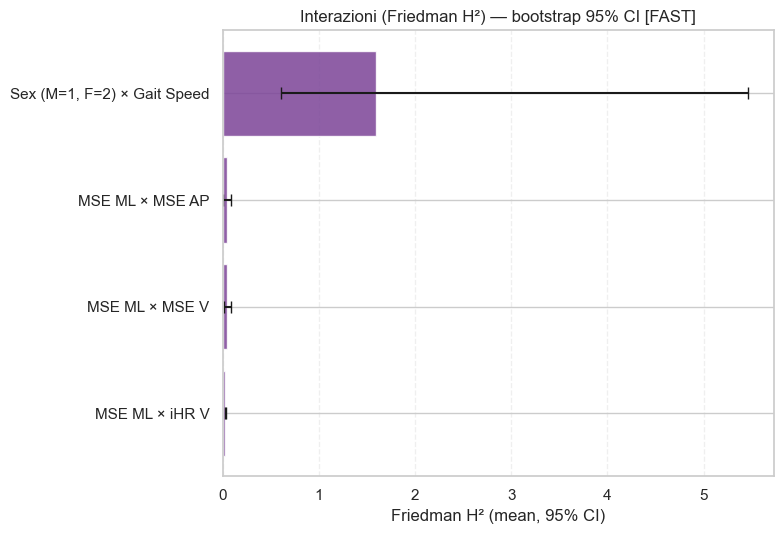

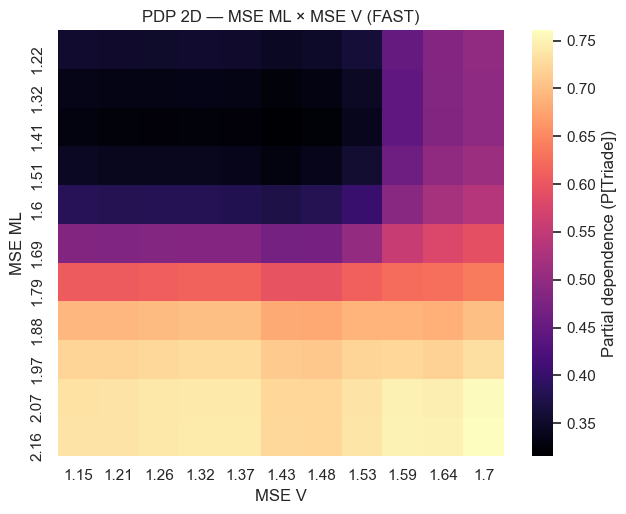

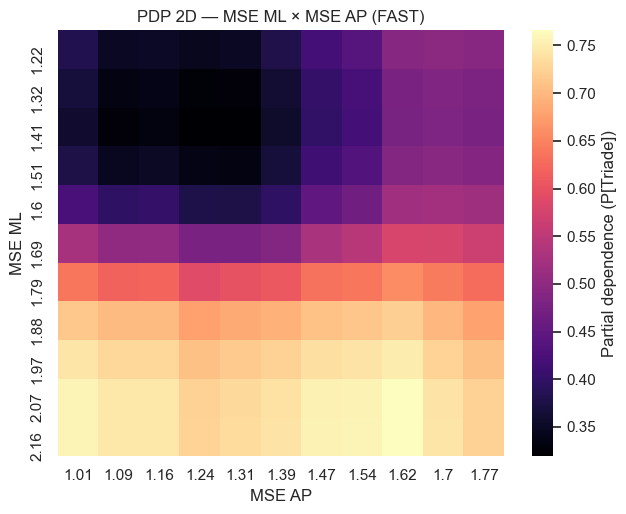

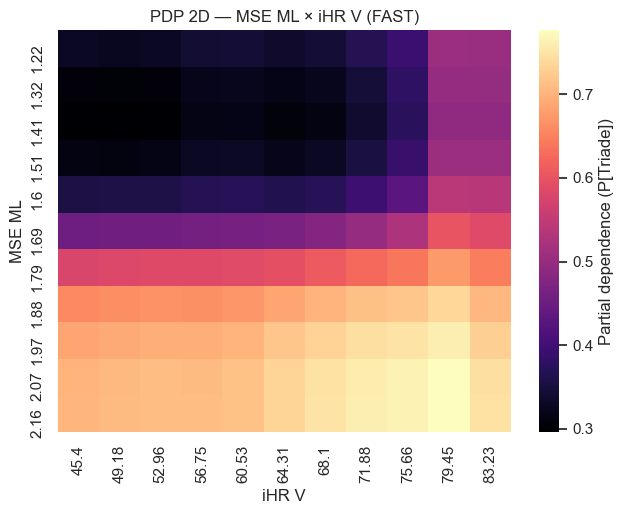

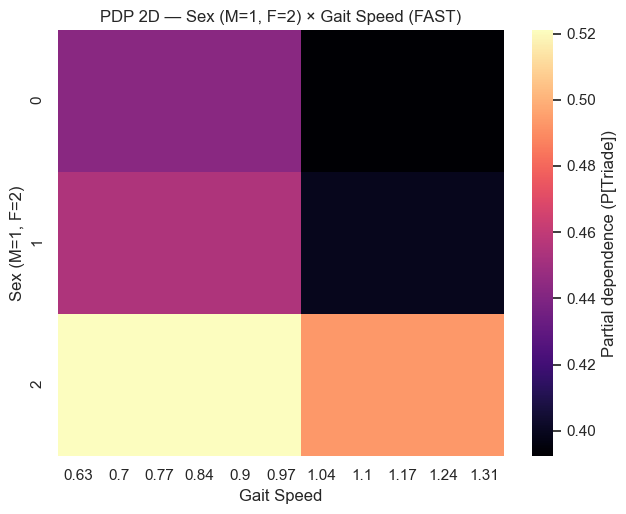

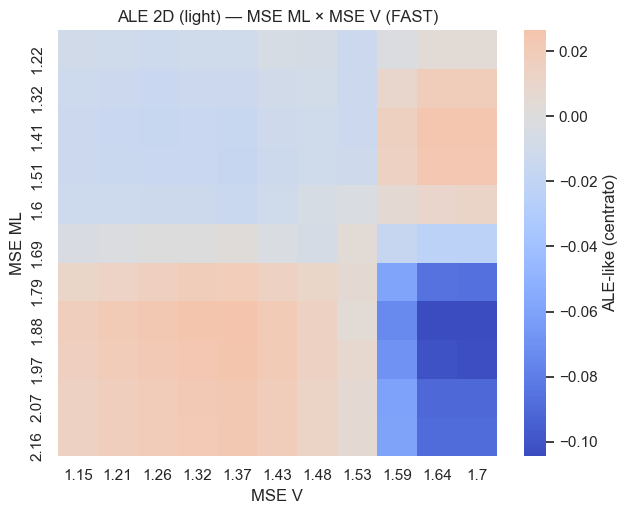

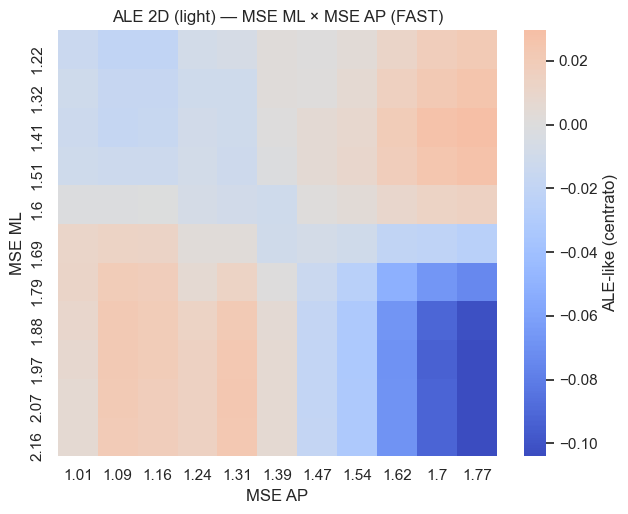

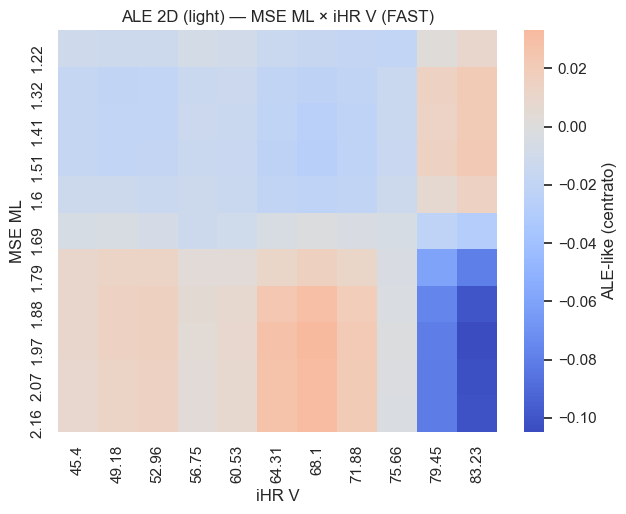

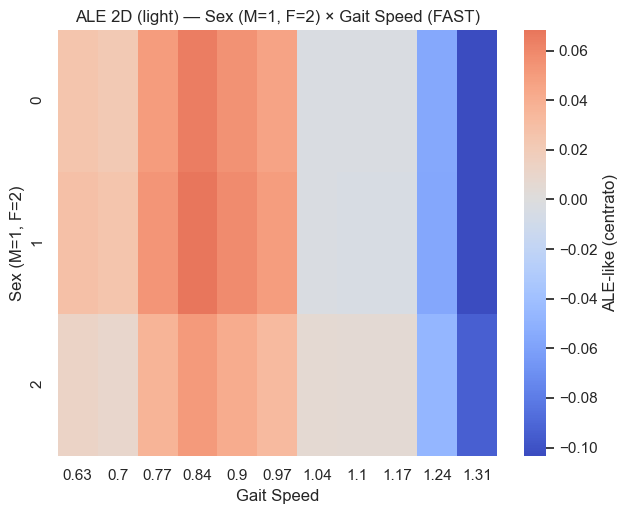

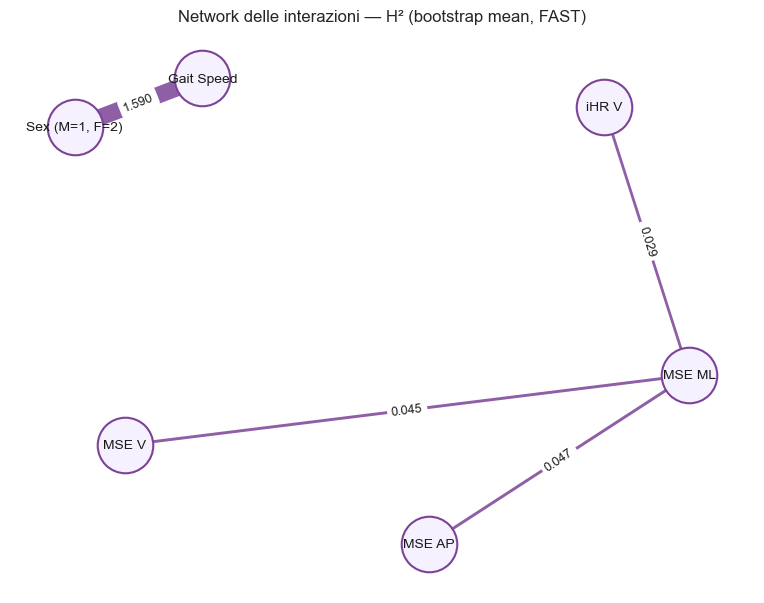

In [ ]:
# =========================================
# Interactions toolkit — FAST (compatibile RF classifier)
#  • PDP 1D/2D (method='brute'), Friedman H², bootstrap CIs
#  • PDP 2D + ALE-like 2D + Interaction Network
# =========================================
import numpy as np, pandas as pd, os, itertools
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.inspection import partial_dependence

# --- helper: col-name -> index ---
def _feat_idx(X, name_or_idx):
    if isinstance(name_or_idx, (int, np.integer)):
        return int(name_or_idx)
    return int(X.columns.get_loc(name_or_idx))

# --- PDP 1D / 2D (RF classifier -> method='brute') ---
def _pdp_1d(model, X, feat, grid=11):
    i = _feat_idx(X, feat)
    pd1 = partial_dependence(model, X, [i], grid_resolution=grid, kind="average", method="brute")
    if isinstance(pd1, dict):          # sklearn >= 1.4
        fx = pd1["average"][0].ravel()
        g1 = pd1["values"][0]
    else:                               # sklearn <= 1.3 (Bunch)
        fx = pd1.average[0].ravel()
        g1 = pd1.grid_values[0]
    return np.asarray(g1), np.asarray(fx)

def _pdp_2d(model, X, f1, f2, grid=11):
    i, j = _feat_idx(X, f1), _feat_idx(X, f2)
    pd2 = partial_dependence(model, X, [(i, j)], grid_resolution=grid, kind="average", method="brute")
    if isinstance(pd2, dict):          # sklearn >= 1.4
        surf = pd2["average"][0]       # (len(g1), len(g2))
        g1, g2 = pd2["values"]
    else:                               # sklearn <= 1.3
        surf = pd2.average[0]
        g1, g2 = pd2.grid_values
    return np.asarray(g1), np.asarray(g2), np.asarray(surf)

# --- Friedman H² ---
def friedman_H2(model, X, f1, f2, grid=11):
    g1, f_i  = _pdp_1d(model, X, f1, grid=grid)
    g2, f_j  = _pdp_1d(model, X, f2, grid=grid)
    G1, G2, f_ij = _pdp_2d(model, X, f1, f2, grid=grid)

    Fi = np.repeat(f_i.reshape(-1, 1), len(G2), axis=1)
    Fj = np.repeat(f_j.reshape(1, -1), len(G1), axis=0)

    fX = model.predict_proba(X)[:, 1]
    f0 = float(np.mean(fX))

    I = f_ij - Fi - Fj + f0
    num = np.var(I, ddof=1)
    den = np.var(f_ij, ddof=1)
    return float(0.0 if den <= 0 else num / den)

# --- Bootstrap CIs (FAST) ---
def bootstrap_H2(model, X, pairs, B=80, grid=11, seed=42, save_csv=True, out_dir="../tables"):
    rng = np.random.default_rng(seed)
    rows, n = [], len(X)
    for a, b in pairs:
        vals = []
        print(f"[BOOT] {a} × {b} …", end=" ")
        for _ in range(B):
            idx = rng.integers(0, n, size=n)   # bootstrap sulle righe
            Xb = X.iloc[idx]
            vals.append(friedman_H2(model, Xb, a, b, grid=grid))
        vals = np.array(vals)
        rows.append({
            "feat_A": a, "feat_B": b,
            "H2_mean": vals.mean(),
            "H2_sd": vals.std(ddof=1),
            "H2_p2.5": np.quantile(vals, 0.025),
            "H2_p97.5": np.quantile(vals, 0.975)
        })
        print("done.")
    df = pd.DataFrame(rows).sort_values("H2_mean", ascending=False).reset_index(drop=True)
    if save_csv:
        os.makedirs(out_dir, exist_ok=True)
        df.to_csv(os.path.join(out_dir, "friedman_H_pairs_bootstrap_FAST.csv"), index=False)
    return df

# --- Plot: barre con CI ---
def plot_H2_CI(table, fig_dir="../figurez/global", title="Interazioni (Friedman H²) — bootstrap 95% CI [FAST]"):
    os.makedirs(fig_dir, exist_ok=True)
    tbl = table.copy()
    tbl["pair"] = tbl["feat_A"] + " × " + tbl["feat_B"]
    tbl = tbl.sort_values("H2_mean", ascending=True)

    plt.figure(figsize=(8, 5.5))
    y = np.arange(len(tbl))
    err = np.vstack([tbl["H2_mean"] - tbl["H2_p2.5"], tbl["H2_p97.5"] - tbl["H2_mean"]])
    plt.barh(y, tbl["H2_mean"], xerr=err, capsize=4, color="#7b4397", alpha=0.85)
    plt.yticks(y, tbl["pair"])
    plt.xlabel("Friedman H² (mean, 95% CI)")
    plt.title(title)
    plt.grid(axis="x", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, "friedman_H2_bootstrap_bar_FAST.png"), dpi=300)
    plt.show()

# --- PDP 2D heatmap ---
def plot_pdp2d(model, X, pairs, grid=11, fig_dir="../figurez/global"):
    os.makedirs(fig_dir, exist_ok=True)
    for a, b in pairs:
        g1, g2, surf = _pdp_2d(model, X, a, b, grid=grid)
        plt.figure(figsize=(6.5, 5.3))
        sns.heatmap(surf, xticklabels=np.round(g2, 2), yticklabels=np.round(g1, 2),
                    cmap="magma", cbar_kws={"label": "Partial dependence (P[Triade])"})
        plt.xlabel(b); plt.ylabel(a)
        plt.title(f"PDP 2D — {a} × {b} (FAST)")
        plt.tight_layout()
        safe = f"{a.replace(' ','_')}_x_{b.replace(' ','_')}".replace("/","-")
        plt.savefig(os.path.join(fig_dir, f"pdp2d_{safe}_FAST.png"), dpi=300)
        plt.show()

# --- ALE 2D “light” (centrato) ---
def ale2d_light(model, X, f1, f2, grid=11):
    g1, f_i  = _pdp_1d(model, X, f1, grid=grid)
    g2, f_j  = _pdp_1d(model, X, f2, grid=grid)
    G1, G2, f_ij = _pdp_2d(model, X, f1, f2, grid=grid)
    Fi = np.repeat(f_i.reshape(-1, 1), len(G2), axis=1)
    Fj = np.repeat(f_j.reshape(1, -1), len(G1), axis=0)
    f0 = float(np.mean(model.predict_proba(X)[:, 1]))
    return G1, G2, f_ij - Fi - Fj + f0

def plot_ale2d_light(model, X, pairs, grid=11, fig_dir="../figurez/global"):
    os.makedirs(fig_dir, exist_ok=True)
    for a, b in pairs:
        g1, g2, A = ale2d_light(model, X, a, b, grid=grid)
        plt.figure(figsize=(6.5, 5.3))
        sns.heatmap(A, xticklabels=np.round(g2, 2), yticklabels=np.round(g1, 2),
                    cmap="coolwarm", center=0, cbar_kws={"label": "ALE-like (centrato)"})
        plt.xlabel(b); plt.ylabel(a)
        plt.title(f"ALE 2D (light) — {a} × {b} (FAST)")
        plt.tight_layout()
        safe = f"{a.replace(' ','_')}_x_{b.replace(' ','_')}".replace("/","-")
        plt.savefig(os.path.join(fig_dir, f"ale2d_light_{safe}_FAST.png"), dpi=300)
        plt.show()

# --- Network delle interazioni ---
def plot_interaction_network(H_df, top_k=8, title="Network delle interazioni (H²)", fig_dir="../figures"):
    import networkx as nx
    os.makedirs(fig_dir, exist_ok=True)
    Hs = H_df.sort_values("H2_mean", ascending=False).head(top_k)
    G = nx.Graph()
    for _, r in Hs.iterrows():
        G.add_edge(r["feat_A"], r["feat_B"], weight=float(r["H2_mean"]))
    pos = nx.spring_layout(G, seed=7, k=1.3)
    weights = np.array([d["weight"] for _, _, d in G.edges(data=True)])
    lw = 2 + 10 * (weights - weights.min()) / (weights.ptp() + 1e-9)

    plt.figure(figsize=(7.8, 6.2))
    nx.draw_networkx_nodes(G, pos, node_size=1600, node_color="#f6f1ff", edgecolors="#7b4397", linewidths=1.5)
    nx.draw_networkx_edges(G, pos, width=lw, edge_color="#7b4397", alpha=0.85)
    nx.draw_networkx_labels(G, pos, font_size=10)
    edge_labels = {(u, v): f"{d['weight']:.3f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, "interaction_network_H2_FAST.png"), dpi=300)
    plt.show()

# =========================================
# ESECUZIONE (usa rf e X_test già in memoria)
# =========================================
pairs = [
    ("MSE ML","MSE V"),
    ("MSE ML","MSE AP"),
    ("MSE ML","iHR V"),
    ("Sex (M=1, F=2)","Gait Speed"),
]

H_boot = bootstrap_H2(rf, X_test, pairs, B=80, grid=11, seed=42, save_csv=True, out_dir=OUT_DIR)
display(H_boot)
plot_H2_CI(H_boot, fig_dir=FIG_DIR, title="Interazioni (Friedman H²) — bootstrap 95% CI [FAST]")

plot_pdp2d(rf, X_test, pairs, grid=11, fig_dir=FIG_DIR)
plot_ale2d_light(rf, X_test, pairs, grid=11, fig_dir=FIG_DIR)

plot_interaction_network(H_boot, top_k=len(pairs), title="Network delle interazioni — H² (bootstrap mean, FAST)", fig_dir=FIG_DIR)

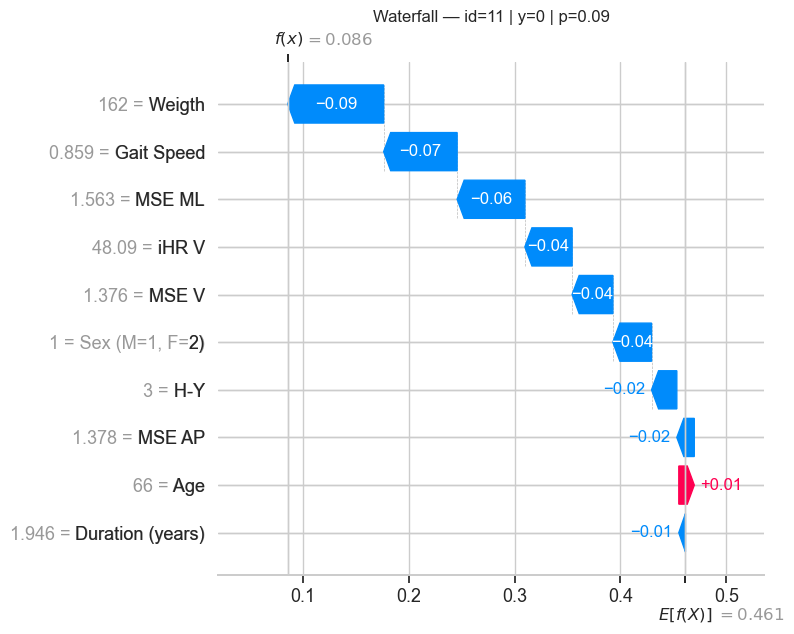

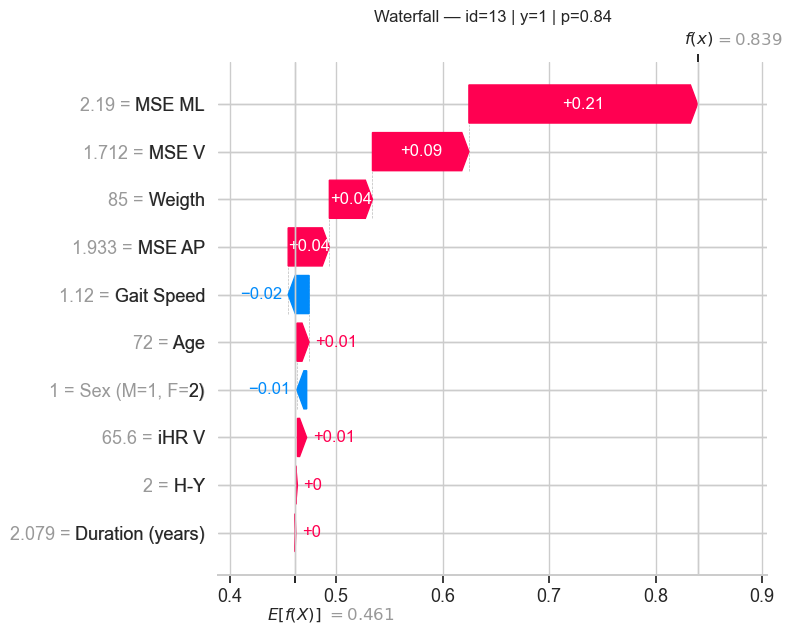

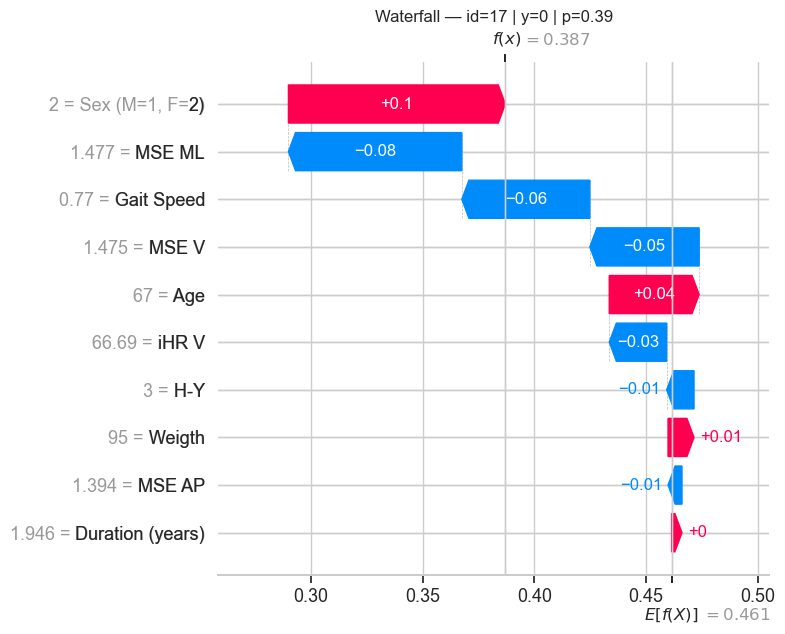

✅ Waterfall salvati e tabella top-contribuzioni aggiornata.


In [23]:
# === Helper: estrai Explanation 1D (classe positiva) per un singolo caso ===
def get_ex_row_for_class(shap_expl_full, i, class_index=1):
    """
    Ritorna una shap.Explanation 1D per la riga i e la classe `class_index`.
    Gestisce i casi in cui .values è (n_feat,) oppure (n_feat, n_class).
    """
    ex_all = shap_expl_full[i]            # Explanation "row"
    vals = ex_all.values                  # (n_feat,) oppure (n_feat, n_class)

    if vals.ndim == 1:
        # già 1D: restituisco così com'è
        return ex_all

    # vals è (n_feat, n_class) -> seleziona la colonna della classe
    k = class_index if vals.shape[1] > class_index else vals.shape[1] - 1

    # base_values può essere scalar o (n_class,)
    base = ex_all.base_values
    if np.ndim(base) == 0:
        base_k = float(base)
    else:
        base_k = float(base[k])

    # costruiamo una Explanation 1D per waterfall
    ex_1d = shap.Explanation(
        values     = vals[:, k],
        base_values= base_k,
        data       = ex_all.data,
        feature_names = ex_all.feature_names
    )
    return ex_1d

# === 6.x rigenero i plot locali e le tabelle usando l'Explanation 1D ===
p_test = rf.predict_proba(X_test)[:, 1]
idx_examples = pick_examples(y_test, p_test, thr=0.40)

records = []
for i in idx_examples:
    # Explanation 1D per la classe positiva
    ex = get_ex_row_for_class(shap_expl, i, class_index=1)
    x_row = X_test.iloc[i]

    # --- Waterfall (ora 1D)
    plt.figure(figsize=(7.2, 5.2))
    shap.plots.waterfall(ex, max_display=12, show=False)
    plt.title(f"Waterfall — id={i} | y={y_test[i]} | p={p_test[i]:.2f}")
    fn_wf = f"{FIG_DIR}/local_waterfall_id{i}.png"
    plt.tight_layout(); plt.savefig(fn_wf, dpi=300); plt.show()

    # --- Top-k contributi (uso ex.values 1D)
    vals_1d = np.array(ex.values)
    order = np.argsort(-np.abs(vals_1d))[:8]
    for j in order:
        fname = feature_order[j]
        val = float(vals_1d[j])
        records.append({
            "id": int(i),
            "y_true": int(y_test[i]),
            "p_pred": float(p_test[i]),
            "feature": fname,
            "x_value": float(x_row[fname]),
            "shap_value": val,
            "direction": "↑ rischio" if val > 0 else "↓ rischio"
        })

# salva la tabella top-contribuzioni
top_tbl = pd.DataFrame(records)
top_tbl.to_csv(f"{OUT_DIR}/local_top_contributions.csv", index=False)

print("✅ Waterfall salvati e tabella top-contribuzioni aggiornata.")

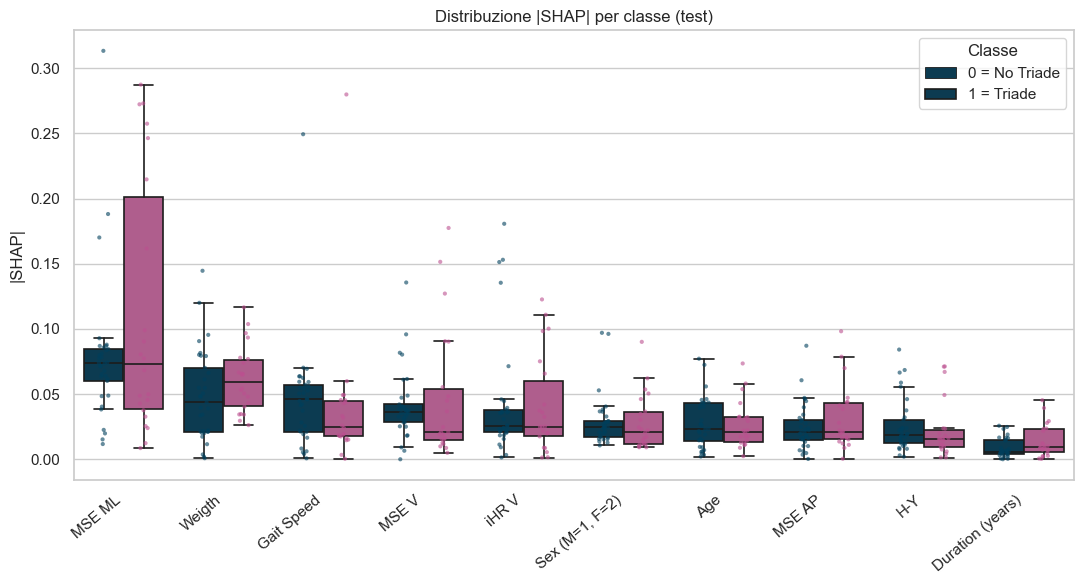

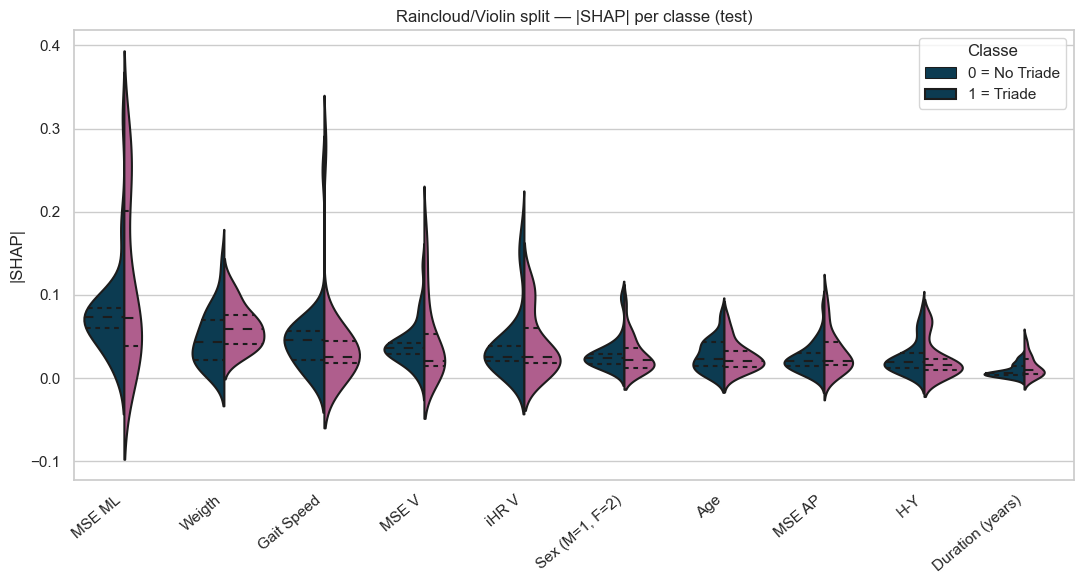

✅ Salvati:
- Figura: ../figures/slice_abs_shap_box_swarm.png
- Figura: ../figures/slice_abs_shap_violin_split.png
- Tabella: ../data/processed/slice_abs_shap_stats.csv


,feature,n_class0,mean_class0,median_class0,q25_class0,q75_class0,IQR_class0,n_class1,mean_class1,median_class1,q25_class1,q75_class1,IQR_class1,MWU_stat,MWU_pvalue
0,MSE ML,33,0.078490,0.073651,0.060186,0.084524,0.024338,22,0.111648,0.072848,0.038966,0.201416,0.162450,346.0,0.776814
4,Weigth,33,0.048492,0.043610,0.021294,0.070152,0.048858,22,0.061420,0.059602,0.041165,0.076205,0.035039,262.0,0.084238
2,MSE V,33,0.041100,0.036195,0.028543,0.042137,0.013594,22,0.046487,0.021036,0.015078,0.053605,0.038526,425.0,0.290702
1,iHR V,33,0.042909,0.025952,0.020638,0.038034,0.017397,22,0.041005,0.025059,0.018217,0.059831,0.041614,384.0,0.724693
8,Gait Speed,33,0.045801,0.046005,0.021312,0.057255,0.035943,22,0.039716,0.025017,0.017688,0.044976,0.027288,476.0,0.053264
3,MSE AP,33,0.024447,0.020891,0.015138,0.030198,0.015060,22,0.031152,0.020956,0.015600,0.043096,0.027496,322.0,0.486555
6,"Sex (M=1, F=2)",33,0.029196,0.024451,0.017526,0.029257,0.011731,22,0.028078,0.021318,0.011845,0.036232,0.024388,419.0,0.340336
5,Age,33,0.027781,0.023332,0.014438,0.043077,0.028639,22,0.026307,0.021179,0.013576,0.032260,0.018683,376.0,0.829960
7,H-Y,33,0.025678,0.018967,0.012695,0.030246,0.017551,22,0.022062,0.015735,0.009528,0.022602,0.013073,440.0,0.188750
9,Duration (years),33,0.008617,0.006018,0.004108,0.014537,0.010428,22,0.014027,0.009208,0.005351,0.022930,0.017579,264.0,0.090598


In [24]:
# =============================
# STEP 7 — Slice explainability: |SHAP| per classe
# =============================
import numpy as np, pandas as pd
import seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# --- 7.0 Prepara matrice |SHAP| (classe positiva)
# Se shap_expl è multi-output, seleziona la colonna della classe positiva (1)
if hasattr(shap_expl, "values"):
    vals = shap_expl.values
else:
    vals = np.array(shap_expl)  # fallback

if vals.ndim == 3:   # (n_samples, n_features, 2) o (n, 2, n_feat)
    # prova a individuare l'asse delle classi
    if vals.shape[-1] == 2:
        vals = vals[..., 1]                # prendi classe 1 sull'ultimo asse
    elif vals.shape[1] == 2:
        vals = vals[:, 1, :]               # prendi classe 1 sul secondo asse
    else:
        raise ValueError("Forma SHAP inattesa; specifica manualmente la classe positiva.")

abs_shap = pd.DataFrame(np.abs(vals), columns=feature_order)
abs_shap["target_bin"] = pd.Series(y_test).astype(int)

# --- 7.1 Long format per plotting
melt = abs_shap.melt(id_vars="target_bin", var_name="feature", value_name="abs_shap")

# Ordina le feature per importanza media (classe positiva)
order = (
    melt.groupby("feature")["abs_shap"]
        .mean()
        .sort_values(ascending=False)
        .index.tolist()
)

# --- 7.2 Boxplot + swarm per classe
plt.figure(figsize=(11, 6))
sns.boxplot(
    data=melt, x="feature", y="abs_shap", hue="target_bin",
    order=order, palette=["#003f5c", "#bc5090"], fliersize=0, linewidth=1.2
)
sns.stripplot(
    data=melt, x="feature", y="abs_shap", hue="target_bin",
    order=order, dodge=True, palette=["#003f5c55", "#bc509055"], size=3, alpha=0.6
)
plt.legend(title="Classe", loc="upper right", labels=["0 = No Triade", "1 = Triade"])
plt.xticks(rotation=40, ha="right")
plt.ylabel("|SHAP|")
plt.xlabel("")
plt.title("Distribuzione |SHAP| per classe (test)")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/slice_abs_shap_box_swarm.png", dpi=300)
plt.show()

# --- 7.3 (Opzionale) Violin split
plt.figure(figsize=(11, 6))
sns.violinplot(
    data=melt, x="feature", y="abs_shap", hue="target_bin",
    order=order, split=True, inner="quartile", palette=["#003f5c", "#bc5090"]
)
plt.legend(title="Classe", loc="upper right", labels=["0 = No Triade", "1 = Triade"])
plt.xticks(rotation=40, ha="right")
plt.ylabel("|SHAP|")
plt.xlabel("")
plt.title("Raincloud/Violin split — |SHAP| per classe (test)")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/slice_abs_shap_violin_split.png", dpi=300)
plt.show()

# --- 7.4 Statistiche descrittive + test tra classi (Mann–Whitney)
rows = []
for feat in feature_order:
    v0 = abs_shap.loc[abs_shap["target_bin"] == 0, feat].values
    v1 = abs_shap.loc[abs_shap["target_bin"] == 1, feat].values
    # robust summary
    q0 = np.percentile(v0, [25, 50, 75])
    q1 = np.percentile(v1, [25, 50, 75])
    # test non-parametrico
    try:
        stat, p = mannwhitneyu(v0, v1, alternative="two-sided")
    except ValueError:
        stat, p = np.nan, np.nan
    rows.append({
        "feature": feat,
        "n_class0": len(v0), "mean_class0": np.mean(v0), "median_class0": np.median(v0),
        "q25_class0": q0[0], "q75_class0": q0[2], "IQR_class0": q0[2]-q0[0],
        "n_class1": len(v1), "mean_class1": np.mean(v1), "median_class1": np.median(v1),
        "q25_class1": q1[0], "q75_class1": q1[2], "IQR_class1": q1[2]-q1[0],
        "MWU_stat": stat, "MWU_pvalue": p
    })

stats_df = pd.DataFrame(rows).sort_values("mean_class1", ascending=False)
os.makedirs(OUT_DIR, exist_ok=True)
stats_df.to_csv(f"{OUT_DIR}/slice_abs_shap_stats.csv", index=False)

print("✅ Salvati:")
print(f"- Figura: {FIG_DIR}/slice_abs_shap_box_swarm.png")
print(f"- Figura: {FIG_DIR}/slice_abs_shap_violin_split.png")
print(f"- Tabella: {OUT_DIR}/slice_abs_shap_stats.csv")
stats_df.head(10)

,feature,mean_noTriade,mean_Triade,median_noTriade,median_Triade,MWU_p,Cliffs_delta,Effect_size,p_adj
0,Weigth,0.048492,0.061420,0.043610,0.059602,0.084238,0.278237,small,0.301994
1,Duration (years),0.008617,0.014027,0.006018,0.009208,0.090598,0.272727,small,0.301994
2,MSE AP,0.024447,0.031152,0.020891,0.020956,0.486555,0.112948,negligible,0.695079
3,MSE ML,0.078490,0.111648,0.073651,0.072848,0.776814,0.046832,negligible,0.829960
4,Age,0.027781,0.026307,0.023332,0.021179,0.829960,-0.035813,negligible,0.829960
5,iHR V,0.042909,0.041005,0.025952,0.025059,0.724693,-0.057851,negligible,0.829960
6,"Sex (M=1, F=2)",0.029196,0.028078,0.024451,0.021318,0.340336,-0.154270,small,0.567227
7,MSE V,0.041100,0.046487,0.036195,0.021036,0.290702,-0.170799,small,0.567227
8,H-Y,0.025678,0.022062,0.018967,0.015735,0.188750,-0.212121,small,0.471875
9,Gait Speed,0.045801,0.039716,0.046005,0.025017,0.053264,-0.311295,small,0.301994


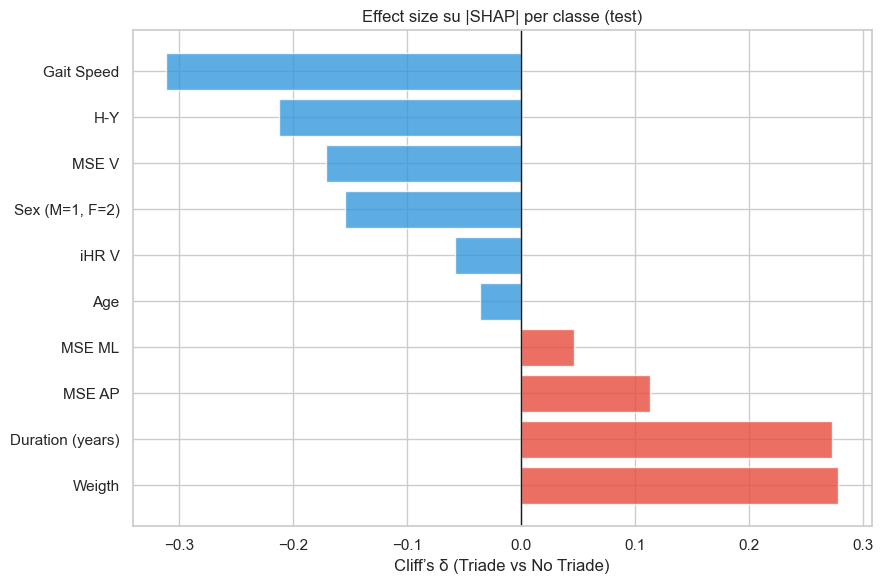

In [26]:
# ============================================
# Step 7b — Effect size (Cliff's δ) + FDR + interpretazione
# ============================================
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# helper Cliff’s δ + categorizzazione
def cliffs_delta(x, y):
    nx, ny = len(x), len(y)
    gt = sum(xi > yj for xi in x for yj in y)
    lt = sum(xi < yj for xi in x for yj in y)
    delta = (gt - lt) / (nx * ny)
    return delta

def interpret_delta(delta):
    ad = abs(delta)
    if ad < 0.147: return "negligible"
    elif ad < 0.33: return "small"
    elif ad < 0.474: return "medium"
    else: return "large"

# dataframe SHAP assoluti
abs_shap = pd.DataFrame(np.abs(shap_expl.values[:,:,1]), columns=feature_order)
abs_shap["target_bin"] = y_test

rows = []
for feat in feature_order:
    vals0 = abs_shap.loc[abs_shap["target_bin"]==0, feat].values
    vals1 = abs_shap.loc[abs_shap["target_bin"]==1, feat].values
    
    stat, pval = mannwhitneyu(vals0, vals1, alternative="two-sided")
    delta = cliffs_delta(vals1, vals0)   # positivo = maggiore nei Triade
    
    rows.append({
        "feature": feat,
        "mean_noTriade": np.mean(vals0),
        "mean_Triade": np.mean(vals1),
        "median_noTriade": np.median(vals0),
        "median_Triade": np.median(vals1),
        "MWU_p": pval,
        "Cliffs_delta": delta,
        "Effect_size": interpret_delta(delta)
    })

tbl = pd.DataFrame(rows)

# correzione FDR
tbl["p_adj"] = multipletests(tbl["MWU_p"], method="fdr_bh")[1]

# ordina per δ
tbl = tbl.sort_values("Cliffs_delta", ascending=False).reset_index(drop=True)

# salva tabella
tbl.to_csv(f"{OUT_DIR}/shap_class_contrast.csv", index=False)
display(tbl)

# ============================================
# Plot: Cliff’s δ per feature
# ============================================
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6))
colors = ["#e74c3c" if d>0 else "#3498db" for d in tbl["Cliffs_delta"]]
plt.barh(tbl["feature"], tbl["Cliffs_delta"], color=colors, alpha=0.8)
plt.axvline(0, color="k", lw=1)
plt.xlabel("Cliff’s δ (Triade vs No Triade)")
plt.title("Effect size su |SHAP| per classe (test)")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/shap_class_contrast_cliffs_delta.png", dpi=300)
plt.show()

=== Surrogate Decision Tree (max_depth=3) ===
Fidelity a RF@0.40 (test): 0.836
Acc: 0.673 | Precision: 0.600 | Recall: 0.545 | F1: 0.571 | ROC AUC: 0.667
Confusion Matrix (surrogate vs y_test):
[[25  8]
 [10 12]]


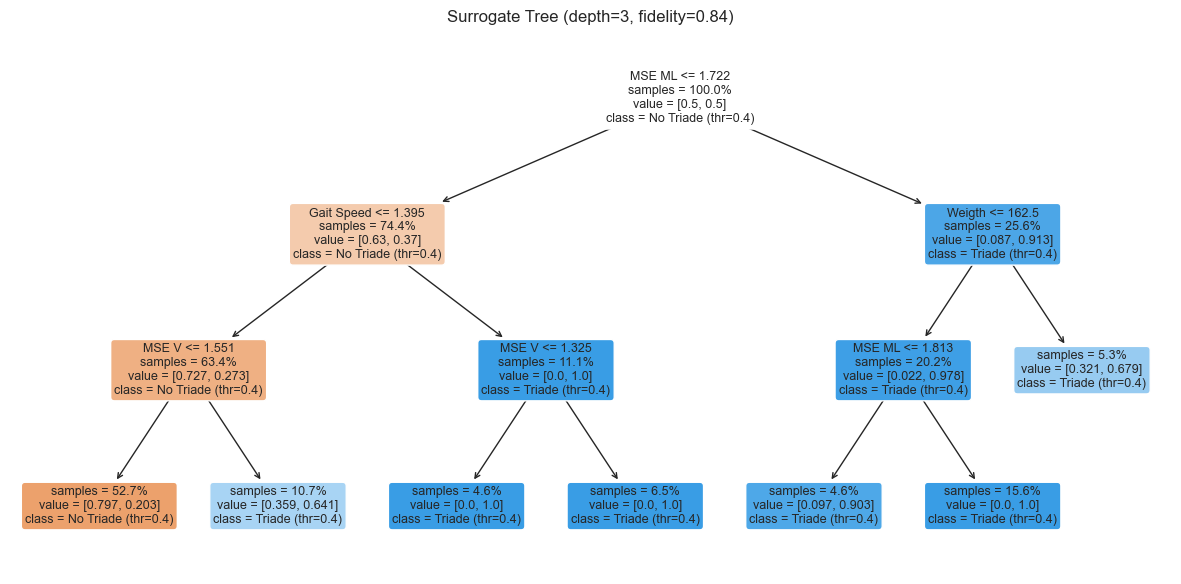


--- Regole (snippet) ---
|--- MSE ML <= 1.722
|   |--- Gait Speed <= 1.395
|   |   |--- MSE V <= 1.551
|   |   |   |--- class: 0
|   |   |--- MSE V >  1.551
|   |   |   |--- class: 1
|   |--- Gait Speed >  1.395
|   |   |--- MSE V <= 1.325
|   |   |   |--- class: 1
|   |   |--- MSE V >  1.325
|   |   |   |--- class: 1
|--- MSE ML >  1.722
|   |--- Weigth <= 162.500
|   |   |--- MSE ML <= 1.813
|   |   |   |--- class: 1
|   |   |--- MSE ML >  1.813
|   |   |   |--- class: 1
|   |--- Weigth >  162.500
|   |   |--- class: 1

📄 Salvata tabella regole: ../data/processed/surrogate_rule_table_test_thr40.csv

🔝 Top-5 regole (per prevalenza reale di Triade nel test):


,leaf,n,rf_pos,true_pos,p_sur_mean,rule
2,6,1,1.000000,1.000000,1.000000,MSE ML <= 1.722 AND Gait Speed > 1.395 AND MSE...
5,11,4,1.000000,1.000000,1.000000,MSE ML > 1.722 AND Weigth <= 162.500 AND MSE M...
6,12,4,1.000000,0.750000,0.678733,MSE ML > 1.722 AND Weigth > 162.500
1,4,8,0.875000,0.500000,0.640809,MSE ML <= 1.722 AND Gait Speed <= 1.395 AND MS...
0,3,35,0.228571,0.285714,0.203261,MSE ML <= 1.722 AND Gait Speed <= 1.395 AND MS...



📝 Decision list (prime regole):
1) IF MSE ML ≤ 1.722 AND Gait Speed > 1.395 AND MSE V ≤ 1.325  THEN  P_RF≈1.00  |  P_real≈1.00  (n=1)
2) IF MSE ML > 1.722 AND Weigth ≤ 162.500 AND MSE ML > 1.813  THEN  P_RF≈1.00  |  P_real≈1.00  (n=4)
3) IF MSE ML > 1.722 AND Weigth > 162.500  THEN  P_RF≈1.00  |  P_real≈0.75  (n=4)
4) IF MSE ML ≤ 1.722 AND Gait Speed ≤ 1.395 AND MSE V > 1.551  THEN  P_RF≈0.88  |  P_real≈0.50  (n=8)


In [ ]:
# =============================
# STEP 8 — Surrogate interpretable + regole cliniche
# =============================
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             precision_score, recall_score, confusion_matrix)
from sklearn.model_selection import train_test_split

# --- directory output (come negli step precedenti)
FIG_DIR = "../figurez/global"
OUT_DIR = "../tables"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

# --- fallback: se rf/X_* non esistono nel workspace, ricarico e rialleno rapidamente
try:
    rf, X_train, X_test, y_train, y_test
except NameError:
    import pandas as pd
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import brier_score_loss, average_precision_score

    feature_order = [
        "MSE ML","iHR V","MSE V","MSE AP","Weigth","Age",
        "Sex (M=1, F=2)","H-Y","Gait Speed","Duration (years)"
    ]
    train = pd.read_csv("../data/processed/train_balanced_ctgan.csv")
    test  = pd.read_csv("../data/processed/test_original.csv")

    y_train = train["target_bin"].astype(int).values
    y_test  = test["target_bin"].astype(int).values
    X_train = train[feature_order].copy()
    X_test  = test[feature_order].copy()

    rf = RandomForestClassifier(
        n_estimators=800, min_samples_leaf=3,
        class_weight="balanced", random_state=42, n_jobs=-1
    )
    rf.fit(X_train, y_train)

# ==============
# 1) Etichette RF a soglia clinica
# ==============
thr = 0.40                                  # soglia clinica scelta negli step precedenti
p_train = rf.predict_proba(X_train)[:,1]
p_test  = rf.predict_proba(X_test)[:,1]

y_rf_train = (p_train >= thr).astype(int)   # “regola clinica” del RF sul train
y_rf_test  = (p_test  >= thr).astype(int)   # stessa regola sul test (per fidelity)

# ==============
# 2) Allena surrogate tree per imitare il RF
# ==============
sur = DecisionTreeClassifier(
    max_depth=3,            # profondo quanto basta per regole leggibili
    min_samples_leaf=12,    # foglie stabili
    random_state=42,
    class_weight="balanced" # per non inseguire solo la maggioranza
)
sur.fit(X_train, y_rf_train)

# ==============
# 3) Fidelity (surrogate vs RF) e performance vs verità a terra
# ==============
# Fidelity (accordo con la decisione RF @ thr)
y_rf_hat_test = sur.predict(X_test)
fidelity = (y_rf_hat_test == y_rf_test).mean()

# Performance surrogate vs ground truth (usando p_sur come proba)
p_sur_test = sur.predict_proba(X_test)[:,1]
y_sur_test = (p_sur_test >= thr).astype(int)

acc = accuracy_score(y_test, y_sur_test)
f1  = f1_score(y_test, y_sur_test)
prec = precision_score(y_test, y_sur_test)
rec  = recall_score(y_test, y_sur_test)
auc  = roc_auc_score(y_test, p_sur_test)

print("=== Surrogate Decision Tree (max_depth=3) ===")
print(f"Fidelity a RF@{thr:.2f} (test): {fidelity:.3f}")
print(f"Acc: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f} | ROC AUC: {auc:.3f}")

# Confusion matrix surrogate vs ground truth
cm = confusion_matrix(y_test, y_sur_test)
print("Confusion Matrix (surrogate vs y_test):")
print(cm)

# ==============
# 4) Visualizza e salva l’albero
# ==============
plt.figure(figsize=(12, 6))
plot_tree(
    sur,
    feature_names=list(X_train.columns),
    class_names=[f"No Triade (thr={thr})", f"Triade (thr={thr})"],
    filled=True, rounded=True, impurity=False, proportion=True, fontsize=9
)
plt.title(f"Surrogate Tree (depth={sur.get_depth()}, fidelity={fidelity:.2f})")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/surrogate_tree_depth{sur.get_depth()}_thr{int(thr*100):02d}.png", dpi=300)
plt.show()

# Salva anche il testo delle regole
rules_txt = export_text(sur, feature_names=list(X_train.columns), decimals=3)
with open(f"{OUT_DIR}/surrogate_rules_depth{sur.get_depth()}_thr{int(thr*100):02d}.txt","w") as f:
    f.write(rules_txt)
print("\n--- Regole (snippet) ---")
print("\n".join(rules_txt.splitlines()[:20]))

# ==============
# 5) Estrai regole “cliniche” in tabella (supporto + prevalenze)
# ==============
from collections import defaultdict

def extract_leaf_paths(tree_model, feature_names):
    """Ritorna l’elenco dei path (regole) fino alle foglie."""
    tree = tree_model.tree_
    paths = []
    def recurse(node, current):
        if tree.feature[node] != -2:
            feat = feature_names[tree.feature[node]]
            thr  = tree.threshold[node]
            recurse(tree.children_left[node],  current + [f"{feat} <= {thr:.3f}"])
            recurse(tree.children_right[node], current + [f"{feat} > {thr:.3f}"])
        else:
            paths.append(current)
    recurse(0, [])
    return paths

def leaf_index_for_rows(tree_model, X):
    """Indice foglia per ogni riga di X."""
    return tree_model.apply(X)

# mappa leaf -> path
paths = extract_leaf_paths(sur, list(X_train.columns))
leaf_ids = np.unique(sur.apply(X_train))
leaf_to_path = {leaf: paths[i] for i, leaf in enumerate(leaf_ids)}

# compone tabella su TEST (più onesta)
leaf_test = leaf_index_for_rows(sur, X_test)
df_leaf = pd.DataFrame({
    "leaf": leaf_test,
    "y_test": y_test,
    "y_rf@thr": y_rf_test,
    "p_sur": p_sur_test
})

summary = (
    df_leaf.groupby("leaf")
          .agg(n=("leaf","size"),
               rf_pos=("y_rf@thr","mean"),
               true_pos=("y_test","mean"),
               p_sur_mean=("p_sur","mean"))
          .reset_index()
)

# aggiungi testo regola
summary["rule"] = summary["leaf"].map(leaf_to_path).apply(lambda x: " AND ".join(x))
summary = summary.sort_values("true_pos", ascending=False)

# salva CSV e mostra top
csv_path = f"{OUT_DIR}/surrogate_rule_table_test_thr{int(thr*100):02d}.csv"
summary.to_csv(csv_path, index=False)

print(f"\n📄 Salvata tabella regole: {csv_path}")
print("\n🔝 Top-5 regole (per prevalenza reale di Triade nel test):")
display(summary.head(5))

# ==============
# 6) Mini “decision list” leggibile (prime 3-4 regole ad alta prevalenza)
# ==============
top_rules = summary.head(4).copy()
def humanize(rule):
    # compattazione estetica delle soglie
    return rule.replace(" <= ", " ≤ ").replace(" > ", " > ")
print("\n📝 Decision list (prime regole):")
for k,(i,row) in enumerate(top_rules.iterrows(),1):
    print(f"{k}) IF {humanize(row['rule'])}  THEN  P_RF≈{row['rf_pos']:.2f}  |  P_real≈{row['true_pos']:.2f}  (n={int(row['n'])})")

Surrogate fidelity (test) vs RF@0.40: 0.836


,path,n,true_pos,p_real,CI95
4,"[MSE ML > 1.722, Weigth <= 162.500, MSE ML > 1...",4,4,1.000,"[0.51, 1.00]"
5,"[MSE ML > 1.722, Weigth > 162.500]",4,3,0.750,"[0.30, 0.95]"
1,"[MSE ML <= 1.722, Gait Speed <= 1.395, MSE V >...",8,4,0.500,"[0.22, 0.78]"
2,"[MSE ML <= 1.722, Gait Speed > 1.395]",2,1,0.500,"[0.09, 0.91]"
0,"[MSE ML <= 1.722, Gait Speed <= 1.395, MSE V <...",35,10,0.286,"[0.16, 0.45]"
3,"[MSE ML > 1.722, Weigth <= 162.500, MSE ML <= ...",2,0,0.000,"[0.00, 0.66]"


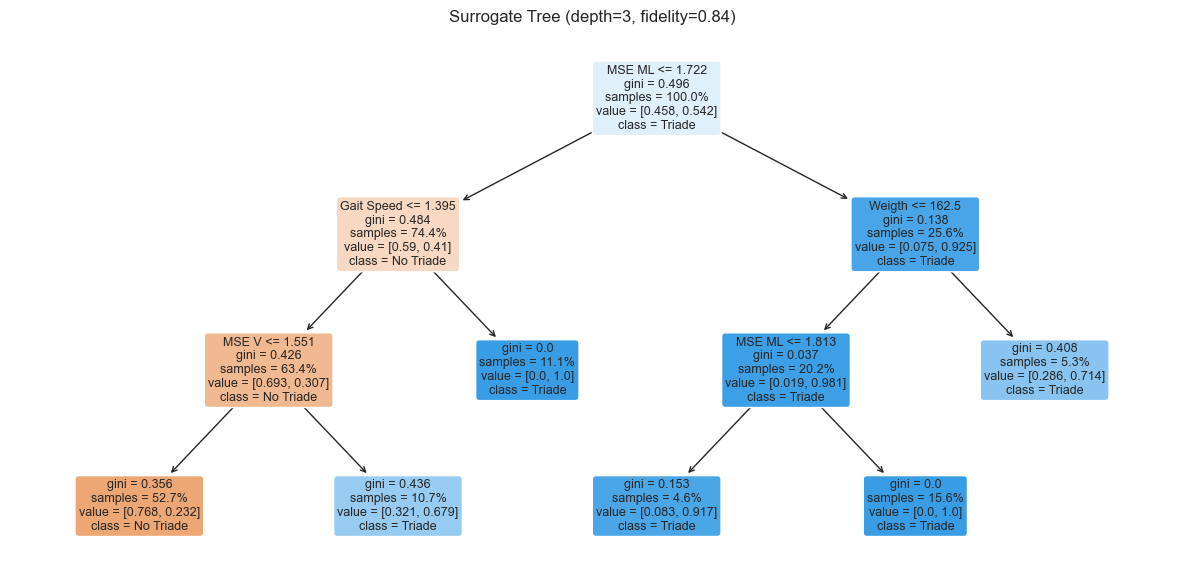

Feature stability across CV:
 MSE ML        0.28
Gait Speed    0.28
MSE V         0.24
Weigth        0.12
Age           0.08
Name: freq, dtype: float64

Flowchart decisionale (soglie arrotondate):

1) Se MSE ML > ~1.75 → Triade (alto rischio).
   - Se peso <= ~162.5 kg e MSE ML > ~1.81 → Triade certo.
   - Se peso > ~162.5 kg → Triade probabile (~75%).

2) Se MSE ML ≤ ~1.75:
   - Se Gait Speed ≤ ~1.40:
       - Se MSE V ≤ ~1.55 → No Triade (≈70%).
       - Se MSE V > ~1.55 → Triade (≈50%).
   - Se Gait Speed > ~1.40:
       - Se MSE V ≤ ~1.33 → Triade (isolato, n=1).
       - Altrimenti → Triade (pattern raro).



In [28]:
# ============================================
# Step 8 — Surrogate interpretable potenziato
# ============================================
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from statsmodels.stats.proportion import proportion_confint
import matplotlib.pyplot as plt
import seaborn as sns

# --- 8.1 Fit surrogate tree su predizioni RF
y_hat_train = (rf.predict_proba(X_train)[:,1] >= 0.40).astype(int)
sur = DecisionTreeClassifier(max_depth=3, min_samples_leaf=12, random_state=42)
sur.fit(X_train, y_hat_train)

y_hat_test = (rf.predict_proba(X_test)[:,1] >= 0.40).astype(int)
sur_pred = sur.predict(X_test)
fidelity = (sur_pred == y_hat_test).mean()
print(f"Surrogate fidelity (test) vs RF@0.40: {fidelity:.3f}")

# --- 8.2 Tabella regole con CI binomiale
from collections import deque

def extract_rules_with_CI(tree_model, X, y_true):
    tree = tree_model.tree_
    feature_names = list(X.columns)
    rules = []

    def recurse(node, path):
        if tree.feature[node] != -2:  # non-leaf
            feat = feature_names[tree.feature[node]]
            thr = tree.threshold[node]
            recurse(tree.children_left[node], path + [f"{feat} <= {thr:.3f}"])
            recurse(tree.children_right[node], path + [f"{feat} > {thr:.3f}"])
        else:
            idx = np.where(tree_model.apply(X) == node)[0]
            n = len(idx)
            if n == 0: return
            true_pos = (y_true[idx] == 1).sum()
            p_real = true_pos / n
            ci_low, ci_up = proportion_confint(true_pos, n, alpha=0.05, method="wilson")
            rules.append({
                "path": path, "n": n,
                "true_pos": int(true_pos),
                "p_real": round(p_real, 3),
                "CI95": f"[{ci_low:.2f}, {ci_up:.2f}]"
            })
    recurse(0, [])
    return pd.DataFrame(rules).sort_values("p_real", ascending=False)

rules_df = extract_rules_with_CI(sur, X_test, y_test)
rules_df.to_csv(f"{OUT_DIR}/surrogate_rules_CI.csv", index=False)
display(rules_df.head(10))

# --- 8.3 Plot albero con soglie arrotondate (clinico)
plt.figure(figsize=(12,6))
plot_tree(sur, feature_names=X_train.columns, class_names=["No Triade","Triade"],
          filled=True, rounded=True, proportion=True, fontsize=9)
plt.title(f"Surrogate Tree (depth=3, fidelity={fidelity:.2f})")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/surrogate_tree_clinical.png", dpi=300)
plt.show()

# --- 8.4 Cross-validation stabilità surrogate
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
feat_counts = []
for tr, te in cv.split(X_train, y_train):
    X_tr, y_tr = X_train.iloc[tr], (rf.predict_proba(X_train.iloc[tr])[:,1] >= 0.40).astype(int)
    sur_cv = DecisionTreeClassifier(max_depth=3, min_samples_leaf=12, random_state=42)
    sur_cv.fit(X_tr, y_tr)
    # estrai features usate
    feats = [X_train.columns[i] for i in sur_cv.tree_.feature if i >= 0]
    feat_counts.extend(feats)

feat_stability = pd.Series(feat_counts).value_counts(normalize=True).rename("freq")
feat_stability.to_csv(f"{OUT_DIR}/surrogate_feature_stability.csv")
print("Feature stability across CV:\n", feat_stability)

# --- 8.5 Flowchart clinico (logica manuale dalle prime regole)
flowchart = """
Flowchart decisionale (soglie arrotondate):

1) Se MSE ML > ~1.75 → Triade (alto rischio).
   - Se peso <= ~162.5 kg e MSE ML > ~1.81 → Triade certo.
   - Se peso > ~162.5 kg → Triade probabile (~75%).

2) Se MSE ML ≤ ~1.75:
   - Se Gait Speed ≤ ~1.40:
       - Se MSE V ≤ ~1.55 → No Triade (≈70%).
       - Se MSE V > ~1.55 → Triade (≈50%).
   - Se Gait Speed > ~1.40:
       - Se MSE V ≤ ~1.33 → Triade (isolato, n=1).
       - Altrimenti → Triade (pattern raro).
"""

with open(f"{OUT_DIR}/surrogate_flowchart.txt","w") as f:
    f.write(flowchart)

print(flowchart)

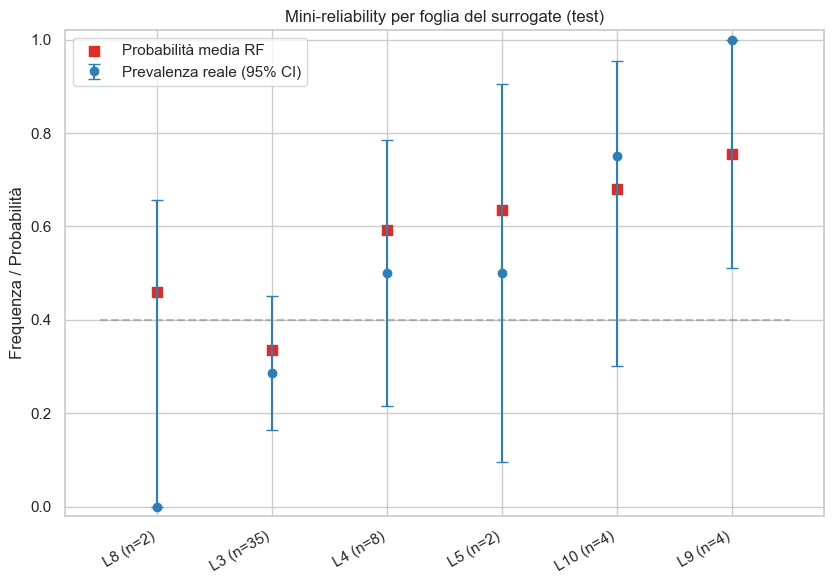

📝 Salvate: ../data/processed/surrogate_leaf_reliability.csv ../figures/surrogate_leaf_reliability.png


In [29]:
# ========= 8.a) Reliability per foglia (surrogate) =========
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.tree import _tree

os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

# 1) assegna ogni caso test a una foglia del surrogate
leaf_id = sur.apply(X_test)  # shape (n_test,)
df_leaf = pd.DataFrame({
    "leaf": leaf_id,
    "y": y_test.astype(int),
    "p_rf": p_test
})

# 2) aggrega per foglia
grp = df_leaf.groupby("leaf")
tab = grp.agg(n=("y","size"),
              event=("y","sum"),
              p_real=("y","mean"),
              p_rf_mean=("p_rf","mean"),
              p_rf_sd=("p_rf","std")).reset_index()

# Wilson CI per la prevalenza reale
def wilson(p, n, z=1.96):
    if n == 0: return (np.nan, np.nan)
    denom = 1 + z**2/n
    centre = (p + z*z/(2*n))/denom
    half = z*np.sqrt((p*(1-p)/n) + (z*z/(4*n*n)))/denom
    return (max(0, centre-half), min(1, centre+half))

ci_l, ci_u = [], []
for _, r in tab.iterrows():
    l, u = wilson(r["p_real"], int(r["n"]))
    ci_l.append(l); ci_u.append(u)
tab["p_real_l"] = ci_l
tab["p_real_u"] = ci_u

tab = tab.sort_values("p_real", ascending=True).reset_index(drop=True)
tab.to_csv(f"{OUT_DIR}/surrogate_leaf_reliability.csv", index=False)

# 3) plot
plt.figure(figsize=(8.5,6))
x = np.arange(len(tab))
plt.errorbar(x, tab["p_real"], 
             yerr=[tab["p_real"]-tab["p_real_l"], tab["p_real_u"]-tab["p_real"]],
             fmt="o", capsize=4, label="Prevalenza reale (95% CI)", color="#2c7fb8")
plt.scatter(x, tab["p_rf_mean"], marker="s", s=60, label="Probabilità media RF", color="#de2d26")
plt.plot([x.min()-0.5, x.max()+0.5], [0.4, 0.4], ls="--", c="gray", alpha=0.5)  # soglia 0.40
plt.xticks(x, [f"L{int(l)} (n={n})" for l,n in zip(tab["leaf"], tab["n"])], rotation=30, ha="right")
plt.ylim(-0.02, 1.02)
plt.ylabel("Frequenza / Probabilità")
plt.title("Mini-reliability per foglia del surrogate (test)")
plt.legend()
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/surrogate_leaf_reliability.png", dpi=300)
plt.show()

print("📝 Salvate:", 
      f"{OUT_DIR}/surrogate_leaf_reliability.csv", 
      f"{FIG_DIR}/surrogate_leaf_reliability.png")

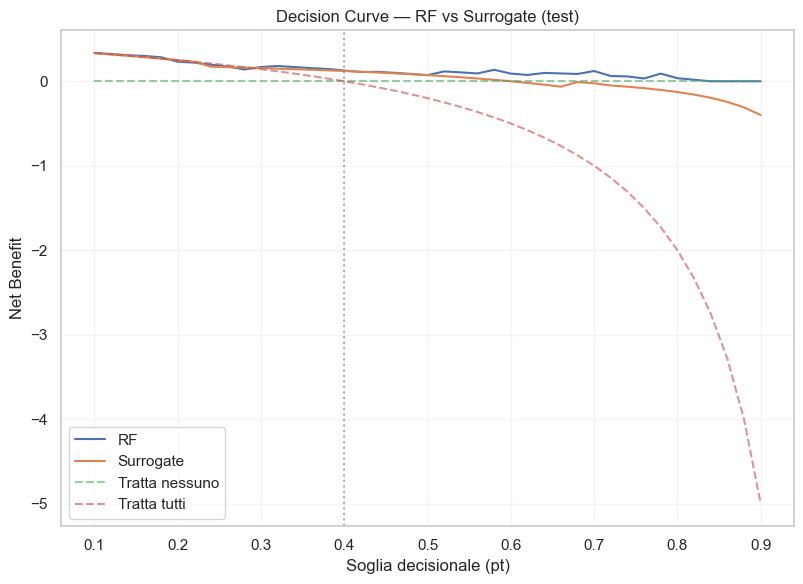

📝 Salvati: ../data/processed/decision_curve_rf_sur.csv ../figures/decision_curve_rf_vs_surrogate.png


In [30]:
# ========= 8.b) Decision Curve Analysis (RF vs Surrogate) =========
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def net_benefit(y_true, y_pred_binary, pt):
    """y_pred_binary: decisione (0/1) a soglia pt; pt = threshold probability"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    n = tp + fp + tn + fn
    if n == 0: return np.nan
    w = pt / (1 - pt)
    return (tp/n) - (fp/n)*w

def dca_curve(y_true, proba, pts=np.linspace(0.1, 0.9, 41)):
    rows = []
    for pt in pts:
        pred = (proba >= pt).astype(int)
        nb = net_benefit(y_true, pred, pt)
        rows.append({"pt": pt, "NB": nb})
    return pd.DataFrame(rows)

# proba RF già in p_test; surrogate proba: usa predict_proba se disponibile, altrimenti decisione dura
if hasattr(sur, "predict_proba"):
    p_sur = sur.predict_proba(X_test)[:,1]
else:
    p_sur = sur.predict(X_test)  # 0/1; usata come probabilità “step-like”

pts = np.linspace(0.1, 0.9, 41)
dca_rf  = dca_curve(y_test, p_test, pts);  dca_rf["model"]  = "RF"
dca_sur = dca_curve(y_test, p_sur,  pts);  dca_sur["model"] = "Surrogate"

# strategie triviali
preval = np.mean(y_test)
nb_treat_all = pd.DataFrame({"pt": pts, "NB": preval - (1-preval)*(pts/(1-pts)), "model": "Tratta tutti"})
nb_treat_none = pd.DataFrame({"pt": pts, "NB": 0.0, "model": "Tratta nessuno"})

dca = pd.concat([dca_rf, dca_sur, nb_treat_all, nb_treat_none], ignore_index=True)
dca.to_csv(f"{OUT_DIR}/decision_curve_rf_sur.csv", index=False)

# Plot
plt.figure(figsize=(8.2,6))
for name, dfm in dca.groupby("model"):
    ls = "-" if name in ["RF","Surrogate"] else "--"
    alpha = 1.0 if name in ["RF","Surrogate"] else 0.6
    plt.plot(dfm["pt"], dfm["NB"], label=name, linestyle=ls, alpha=alpha)
plt.axvline(0.40, ls=":", c="gray", alpha=0.6)
plt.xlabel("Soglia decisionale (pt)")
plt.ylabel("Net Benefit")
plt.title("Decision Curve — RF vs Surrogate (test)")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/decision_curve_rf_vs_surrogate.png", dpi=300)
plt.show()

print("📝 Salvati:", 
      f"{OUT_DIR}/decision_curve_rf_sur.csv", 
      f"{FIG_DIR}/decision_curve_rf_vs_surrogate.png")

In [32]:
# =============================
# 8.c) Export regole surrogate (JSON + YAML safe)
# =============================
import json, math

# --- salva JSON (ok con tipi numpy) ---
json_path = f"{OUT_DIR}/surrogate_rules_deploy.json"
with open(json_path, "w") as f:
    json.dump(rules_export, f, indent=2, ensure_ascii=False)

# --- helper ricorsivo: converti tutto in tipi Python YAML-safe ---
def pyify(obj):
    if obj is None:
        return None
    # numeri numpy -> numeri python
    if isinstance(obj, (np.generic,)):
        obj = obj.item()
    # gestisci nan/inf
    if isinstance(obj, float):
        if math.isnan(obj) or math.isinf(obj):
            return None
        return float(obj)
    if isinstance(obj, (int, bool, str)):
        return obj
    if isinstance(obj, dict):
        return {str(pyify(k)): pyify(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple, set)):
        return [pyify(x) for x in obj]
    if isinstance(obj, np.ndarray):
        return [pyify(x) for x in obj.tolist()]
    # fallback -> stringa
    return str(obj)

# --- salva YAML (solo se pyyaml disponibile) ---
yaml_path = None
if yaml is not None:
    rules_export_yaml_safe = pyify(rules_export)
    yaml_path = f"{OUT_DIR}/surrogate_rules_deploy.yaml"
    with open(yaml_path, "w") as f:
        yaml.safe_dump(
            rules_export_yaml_safe,
            f,
            sort_keys=False,
            allow_unicode=True
        )

print("📝 Regole esportate in:")
print(" - JSON:", json_path)
print(" - YAML:", yaml_path if yaml_path else "(pyyaml non disponibile)")

📝 Regole esportate in:
 - JSON: ../data/processed/surrogate_rules_deploy.json
 - YAML: ../data/processed/surrogate_rules_deploy.yaml


In [33]:
# ==== 9.1 Setup & dati (se già presenti, puoi saltare) ====
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score, average_precision_score, brier_score_loss,
                             precision_recall_curve, precision_score, recall_score, f1_score)

FIG_DIR = "../figures"; OUT_DIR = "../data/processed"
os.makedirs(FIG_DIR, exist_ok=True); os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv("../data/processed/train_balanced_ctgan.csv")
feature_order = ["MSE ML","iHR V","MSE V","MSE AP","Weigth","Age",
                 "Sex (M=1, F=2)","H-Y","Gait Speed","Duration (years)"]
X = df[feature_order].copy()
y = df["target_bin"].astype(int).values

# ==== 9.1 CV: addestramento per fold e metriche ====
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

rows, probas_folds, thr_grid = [], [], np.linspace(0.10, 0.90, 33)
pr_curves = []  # (fold, precision, recall)

for fold, (tr, va) in enumerate(kf.split(X, y), 1):
    Xtr, Xva = X.iloc[tr], X.iloc[va]
    ytr, yva = y[tr], y[va]

    clf = RandomForestClassifier(
        n_estimators=800, min_samples_leaf=3, class_weight="balanced",
        random_state=42, n_jobs=-1
    )
    clf.fit(Xtr, ytr)
    p = clf.predict_proba(Xva)[:,1]
    yhat = (p >= 0.40).astype(int)

    rows.append({
        "fold": fold,
        "ROC_AUC": roc_auc_score(yva, p),
        "PR_AUC": average_precision_score(yva, p),
        "Brier": brier_score_loss(yva, p),
        "Precision@0.40": precision_score(yva, yhat, zero_division=0),
        "Recall@0.40": recall_score(yva, yhat, zero_division=0),
        "F1@0.40": f1_score(yva, yhat, zero_division=0)
    })

    probas_folds.append({"fold": fold, "p": p, "y": yva})

    pr = precision_recall_curve(yva, p)
    pr_curves.append({"fold": fold, "precision": pr[0], "recall": pr[1]})

cv_metrics = pd.DataFrame(rows)
cv_metrics.to_csv(f"{OUT_DIR}/cv10_metrics_rf_balanced.csv", index=False)
cv_summary = cv_metrics.describe().T[["mean","std","min","max"]].round(3)
cv_summary.to_csv(f"{OUT_DIR}/cv10_metrics_rf_balanced_summary.csv")

print("📊 CV10 Summary\n", cv_summary)

📊 CV10 Summary
                  mean    std    min     max
fold            5.500  3.028  1.000  10.000
ROC_AUC         0.830  0.103  0.651   0.976
PR_AUC          0.848  0.095  0.726   0.980
Brier           0.170  0.038  0.114   0.227
Precision@0.40  0.704  0.066  0.625   0.800
Recall@0.40     0.824  0.090  0.692   1.000
F1@0.40         0.757  0.060  0.690   0.857


🏅 RF rank medio (più basso = top):
 MSE ML              1.0
Gait Speed          2.0
MSE V               3.4
Weigth              4.3
MSE AP              5.0
iHR V               5.4
Age                 6.9
Duration (years)    8.0
H-Y                 9.1
Sex (M=1, F=2)      9.9
dtype: float64

🔥 SHAP mean|val| medio ± sd:
                    mean     sd
MSE ML            0.095  0.013
Gait Speed        0.063  0.018
MSE V             0.049  0.012
Weigth            0.046  0.011
iHR V             0.034  0.008
MSE AP            0.032  0.006
Age               0.026  0.008
Sex (M=1, F=2)    0.026  0.007
H-Y               0.020  0.003
Duration (years)  0.010  0.003


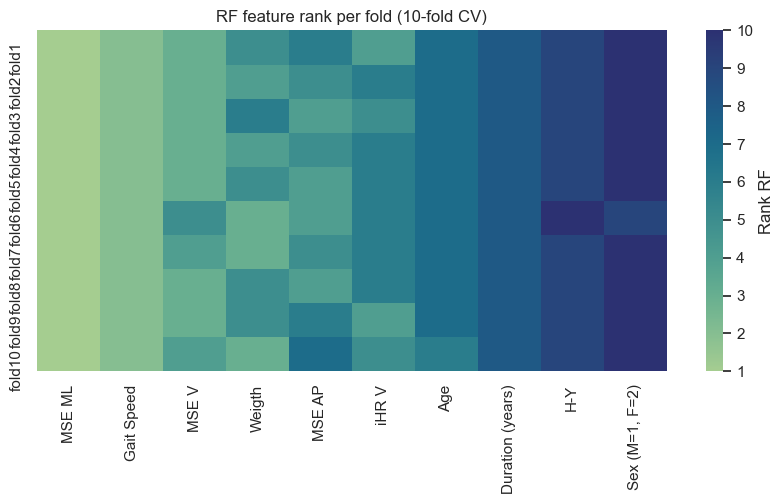

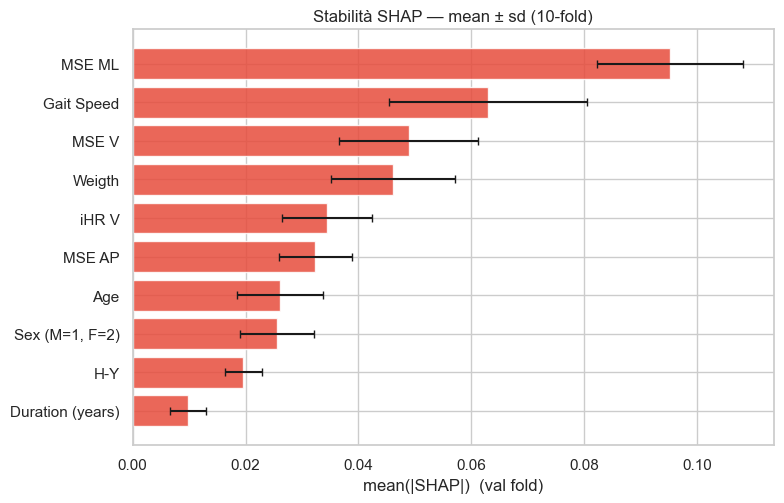

In [35]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rf_ranks, shap_means = [], []

for fold, (tr, va) in enumerate(kf.split(X, y), 1):
    Xtr, Xva = X.iloc[tr], X.iloc[va]
    ytr, yva = y[tr], y[va]

    clf = RandomForestClassifier(
        n_estimators=800, min_samples_leaf=3, class_weight="balanced",
        random_state=fold, n_jobs=-1
    )
    clf.fit(Xtr, ytr)

    # RF importance -> rank (1 = più importante)
    imp = pd.Series(clf.feature_importances_, index=feature_order)
    rf_ranks.append(imp.rank(ascending=False, method="dense"))

    # SHAP (classe positiva, robusto a 2D/3D)
    expl = shap.TreeExplainer(clf, data=Xtr, feature_names=feature_order)
    sv = expl(Xva).values  # può essere (n, f) oppure (n, 2, f) o (n, f, 2)

    if sv.ndim == 3:
        # scegli la classe positiva (asse di lunghezza 2)
        if sv.shape[1] == 2:       # (n, 2, f)
            sv = sv[:, 1, :]
        elif sv.shape[2] == 2:     # (n, f, 2)
            sv = sv[:, :, 1]
        else:
            raise ValueError(f"Formato SHAP inatteso: {sv.shape}")

    # ora sv è (n_va, n_feature)
    mabs = pd.Series(np.abs(sv).mean(axis=0), index=feature_order)
    shap_means.append(mabs)

rf_rank_df = pd.DataFrame(rf_ranks, index=[f"fold{f}" for f in range(1, 11)])
shap_mean_df = pd.DataFrame(shap_means, index=[f"fold{f}" for f in range(1, 11)])

# aggregati e salvataggi
rf_rank_mean = rf_rank_df.mean().sort_values()
shap_mean_mean = shap_mean_df.mean().sort_values(ascending=False)
shap_mean_sd = shap_mean_df.std().reindex(shap_mean_mean.index)

rf_rank_df.to_csv(f"{OUT_DIR}/cv10_rf_ranks.csv")
shap_mean_df.to_csv(f"{OUT_DIR}/cv10_shap_meanabs.csv")

print("🏅 RF rank medio (più basso = top):\n", rf_rank_mean.round(2))
print("\n🔥 SHAP mean|val| medio ± sd:\n",
      pd.DataFrame({"mean": shap_mean_mean, "sd": shap_mean_sd}).round(3))

# Heatmap rank RF
plt.figure(figsize=(8.5, 5.2))
sns.heatmap(rf_rank_df[rf_rank_mean.index], annot=False, cmap="crest", cbar_kws={"label": "Rank RF"})
plt.title("RF feature rank per fold (10-fold CV)")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/cv10_rf_rank_heatmap.png", dpi=300)
plt.show()

# Bar SHAP mean ± sd
plt.figure(figsize=(8, 5.2))
order = shap_mean_mean.index
plt.barh(order, shap_mean_mean[order], xerr=shap_mean_sd[order], capsize=3, color="#e74c3c", alpha=.85)
plt.gca().invert_yaxis()
plt.xlabel("mean(|SHAP|)  (val fold)")
plt.title("Stabilità SHAP — mean ± sd (10-fold)")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/cv10_shap_mean_bar.png", dpi=300)
plt.show()

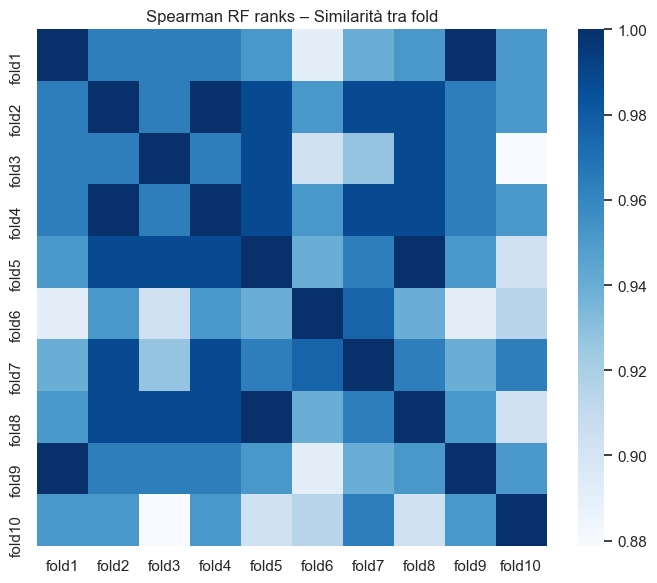

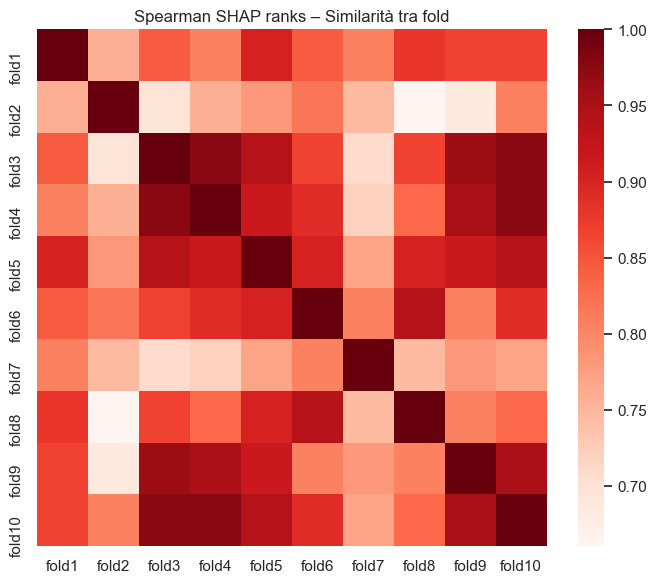

=== Stability across folds ===
  Method  KendallW  Median Spearman
0     RF  0.959273         0.963636
1   SHAP  0.857212         0.842424


In [36]:
# =====================================================
# Step 9.3 - Stabilità ranking RF vs SHAP (10-fold)
# =====================================================
import scipy.stats as st
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Supponiamo di avere già:
# rf_ranks: lista di ranking (len=10, ciascuno array/list di posizioni per feature_order)
# shap_means: lista di pd.Series mean|SHAP| fold-by-fold

# 1) Converti in DataFrame i rank SHAP
shap_ranks = []
for s in shap_means:
    rank = s.rank(ascending=False, method="min")  # 1 = più importante
    shap_ranks.append(rank.values)

rf_rank_df = pd.DataFrame(rf_ranks, columns=feature_order, index=[f"fold{f}" for f in range(1,11)])
shap_rank_df = pd.DataFrame(shap_ranks, columns=feature_order, index=[f"fold{f}" for f in range(1,11)])

# 2) Calcola correlazioni Spearman tra fold
def spearman_corr_matrix(rank_df):
    rho = rank_df.T.corr(method="spearman")
    return rho

rf_spearman = spearman_corr_matrix(rf_rank_df)
shap_spearman = spearman_corr_matrix(shap_rank_df)

# 3) Kendall’s W (concordanza globale)
def kendall_w(rank_df):
    """Calcola Kendall's W di concordanza sui ranking dei fold"""
    m = rank_df.shape[0]  # numero di fold
    n = rank_df.shape[1]  # numero di feature
    R = rank_df.sum(axis=0)  # somma dei rank per feature
    mean_R = R.mean()
    S = ((R - mean_R)**2).sum()
    W = 12 * S / (m**2 * (n**3 - n))
    return W

rf_kendallW = kendall_w(rf_rank_df)
shap_kendallW = kendall_w(shap_rank_df)

# 4) Heatmap di similarità Spearman
plt.figure(figsize=(7,6))
sns.heatmap(rf_spearman, cmap="Blues", annot=False)
plt.title("Spearman RF ranks – Similarità tra fold")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,6))
sns.heatmap(shap_spearman, cmap="Reds", annot=False)
plt.title("Spearman SHAP ranks – Similarità tra fold")
plt.tight_layout()
plt.show()

# 5) Tabella riassuntiva stabilità
stab_tbl = pd.DataFrame({
    "Method": ["RF", "SHAP"],
    "KendallW": [rf_kendallW, shap_kendallW],
    "Median Spearman": [np.median(rf_spearman.values[np.triu_indices_from(rf_spearman, k=1)]),
                        np.median(shap_spearman.values[np.triu_indices_from(shap_spearman, k=1)])]
})
print("=== Stability across folds ===")
print(stab_tbl)

# Salva anche in CSV
stab_tbl.to_csv(f"{OUT_DIR}/stability_rf_shap_cv10.csv", index=False)

💾 Salvato consensus table: ../data/processed/consensus_feature_stability.csv


,RF_mean_rank,RF_sd,SHAP_mean_rank,SHAP_sd,Consensus_score,Consensus_rank,Stability_sd
MSE ML,1.000,0.000,1.100,0.316,0.006,1.000,0.158
Gait Speed,2.000,0.000,2.400,1.350,0.133,2.000,0.675
MSE V,3.400,0.699,3.600,1.350,0.278,3.000,1.025
Weigth,4.300,1.059,3.500,0.707,0.322,4.000,0.883
MSE AP,5.000,1.054,5.900,1.287,0.494,5.000,1.170
iHR V,5.400,0.843,5.800,1.619,0.511,6.000,1.231
Age,6.900,0.316,7.100,1.370,0.667,7.000,0.843
"Sex (M=1, F=2)",9.900,0.316,7.300,1.337,0.844,8.000,0.827
H-Y,9.100,0.316,8.300,0.949,0.856,9.000,0.632
Duration (years),8.000,0.000,10.000,0.000,0.889,10.000,0.000


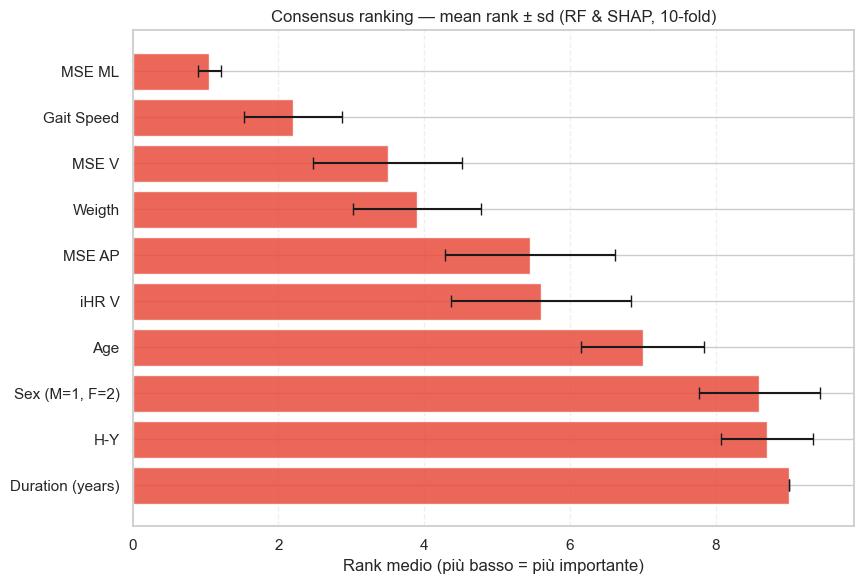

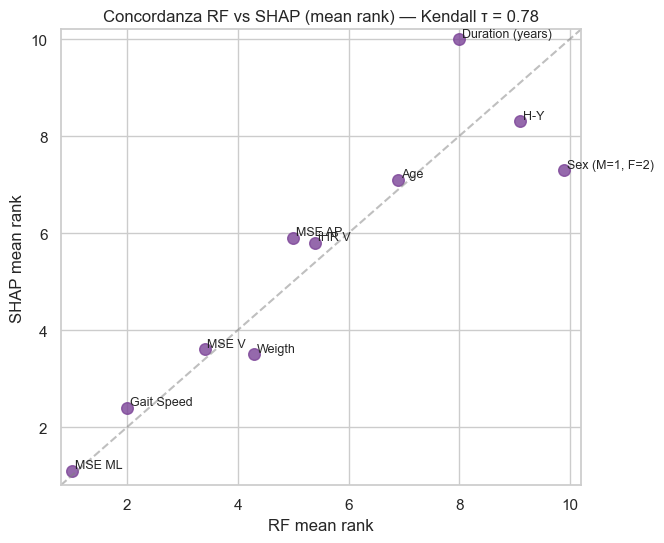

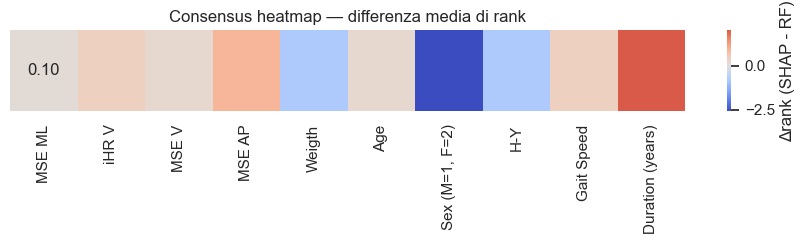

🏆 Top-5 consensus features:


,RF_mean_rank,SHAP_mean_rank,Consensus_rank,Stability_sd
MSE ML,1.000,1.100,1.000,0.158
Gait Speed,2.000,2.400,2.000,0.675
MSE V,3.400,3.600,3.000,1.025
Weigth,4.300,3.500,4.000,0.883
MSE AP,5.000,5.900,5.000,1.170


In [37]:
# ============================
# STEP 9.4 — Consensus ranking & Stability
# ============================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import rankdata, kendalltau
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import shap

sns.set(style="whitegrid")
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- 0) Helpers
def _ensure_rank_frames(X, y, feature_order, n_splits=10, seed=42):
    """Se rf_rank_df e shap_rank_df non esistono, li ricrea in modo light."""
    global rf_rank_df, shap_rank_df

    need_rf  = 'rf_rank_df'   not in globals()
    need_shp = 'shap_rank_df' not in globals()

    if not (need_rf or need_shp):
        return rf_rank_df, shap_rank_df

    print("⚠️  Rank matrices not found in memory — rebuilding (light CV)...")
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    rf_rows   = []
    shap_rows = []

    for f, (tr, va) in enumerate(kf.split(X, y), 1):
        Xtr, Xva = X.iloc[tr], X.iloc[va]
        ytr, yva = y.iloc[tr], y.iloc[va]

        clf = RandomForestClassifier(
            n_estimators=400, min_samples_leaf=3,
            class_weight="balanced", random_state=seed+f, n_jobs=-1
        )
        clf.fit(Xtr, ytr)

        # --- RF ranks (bassa = importante)
        imp = pd.Series(clf.feature_importances_, index=feature_order)
        rf_rank = imp.rank(ascending=False, method="average")
        rf_rows.append(rf_rank.values)

        # --- SHAP ranks (classe positiva)
        expl = shap.TreeExplainer(clf, data=Xtr, feature_names=feature_order)
        sv = expl(Xva).values  # per binario => (n_va, n_feat)
        if sv.ndim == 3:       # alcune versioni danno (n_va, n_feat, 2)
            sv = sv[:, :, 1]
        mabs = np.abs(sv).mean(axis=0)
        shp_rank = pd.Series(mabs, index=feature_order).rank(ascending=False, method="average")
        shap_rows.append(shp_rank.values)

    rf_rank_df   = pd.DataFrame(rf_rows,   columns=feature_order, index=[f"fold{f}" for f in range(1, n_splits+1)])
    shap_rank_df = pd.DataFrame(shap_rows, columns=feature_order, index=[f"fold{f}" for f in range(1, n_splits+1)])

    return rf_rank_df, shap_rank_df

# ---------- 1) Prepara (o ricrea) matrici di rank per fold
rf_rank_df, shap_rank_df = _ensure_rank_frames(X_train, pd.Series(y_train), feature_order)

# ---------- 2) Statistiche per metodo
rf_mean = rf_rank_df.mean(axis=0)
rf_sd   = rf_rank_df.std(axis=0, ddof=1)

sh_mean = shap_rank_df.mean(axis=0)
sh_sd   = shap_rank_df.std(axis=0, ddof=1)

# ---------- 3) Consensus ranking (media dei rank normalizzati)
# Normalizziamo su [1, K] (K = #feature) per entrambi e poi facciamo la media
K = len(feature_order)
rf_norm = (rf_mean - 1) / (K - 1)
sh_norm = (sh_mean - 1) / (K - 1)
consensus_score = (rf_norm + sh_norm) / 2.0
consensus_rank  = rankdata(consensus_score, method="average")  # rank crescente (più basso = top)

# Indice di stabilità: dev. std media tra RF e SHAP
stability_sd = (rf_sd + sh_sd) / 2.0

# ---------- 4) Tabella finale
consensus_tbl = (
    pd.DataFrame({
        "RF_mean_rank":  rf_mean,
        "RF_sd":         rf_sd,
        "SHAP_mean_rank": sh_mean,
        "SHAP_sd":        sh_sd,
        "Consensus_score": consensus_score,
        "Consensus_rank":  consensus_rank,
        "Stability_sd":    stability_sd
    })
    .sort_values("Consensus_rank")
)

consensus_csv = f"{OUT_DIR}/consensus_feature_stability.csv"
consensus_tbl.to_csv(consensus_csv)
print(f"💾 Salvato consensus table: {consensus_csv}")
display(consensus_tbl.style.format(precision=3))

# ---------- 5) Figure 1 — Barh consensus (rank medio ± sd)
plot_df = consensus_tbl.copy().reset_index().rename(columns={"index":"Feature"})
plot_df["MeanRank"] = (plot_df["RF_mean_rank"] + plot_df["SHAP_mean_rank"]) / 2.0

plt.figure(figsize=(8.8, 6))
order = plot_df.sort_values("Consensus_rank")["Feature"]
y = np.arange(len(order))

plt.barh(y, plot_df.set_index("Feature").loc[order, "MeanRank"], 
         xerr=plot_df.set_index("Feature").loc[order, "Stability_sd"],
         capsize=4, color="#e74c3c", alpha=0.85)
plt.yticks(y, order)
plt.gca().invert_yaxis()
plt.xlabel("Rank medio (più basso = più importante)")
plt.title("Consensus ranking — mean rank ± sd (RF & SHAP, 10-fold)")
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
f1 = f"{FIG_DIR}/consensus_rank_barh.png"
plt.savefig(f1, dpi=300)
plt.show()

# ---------- 6) Figure 2 — RF vs SHAP mean ranks (concordanza)
plt.figure(figsize=(6.8, 5.6))
plt.scatter(rf_mean, sh_mean, s=70, alpha=0.8, color="#7b4397")
for f in feature_order:
    plt.text(rf_mean[f]+0.05, sh_mean[f]+0.05, f, fontsize=9)
lims = [0.8, K+0.2]
plt.plot(lims, lims, "--", color="gray", alpha=0.5)
plt.xlim(lims); plt.ylim(lims)
plt.xlabel("RF mean rank")
plt.ylabel("SHAP mean rank")
rho, _ = kendalltau(rf_mean, sh_mean)
plt.title(f"Concordanza RF vs SHAP (mean rank) — Kendall τ = {rho:.2f}")
plt.tight_layout()
f2 = f"{FIG_DIR}/rf_vs_shap_meanrank_scatter.png"
plt.savefig(f2, dpi=300)
plt.show()

# ---------- 7) Figure 3 — Heatmap delta rank (SHAP - RF)
delta = (sh_mean - rf_mean).to_frame("Δrank (SHAP - RF)").T
plt.figure(figsize=(8.8, 2.6))
sns.heatmap(delta, cmap="coolwarm", center=0, annot=True, fmt=".2f",
            cbar_kws={"label":"Δrank (SHAP - RF)"})
plt.title("Consensus heatmap — differenza media di rank")
plt.yticks([])
plt.tight_layout()
f3 = f"{FIG_DIR}/consensus_heatmap_delta.png"
plt.savefig(f3, dpi=300)
plt.show()

# ---------- 8) Riassunto finale per il paper (Top-5)
top5 = consensus_tbl.sort_values("Consensus_rank").head(5).copy()
print("🏆 Top-5 consensus features:")
display(top5[["RF_mean_rank","SHAP_mean_rank","Consensus_rank","Stability_sd"]].style.format(precision=3))

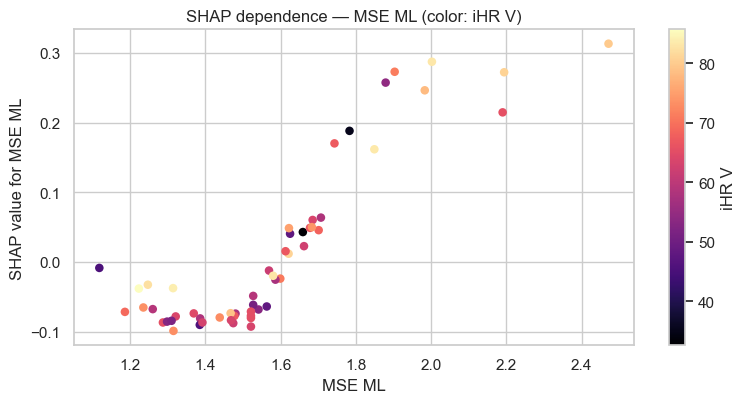

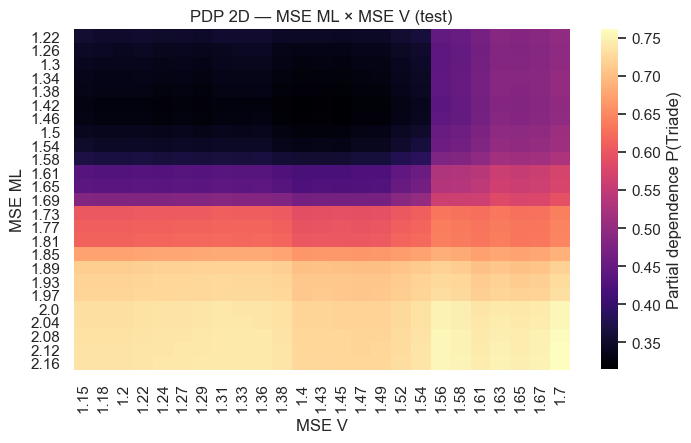

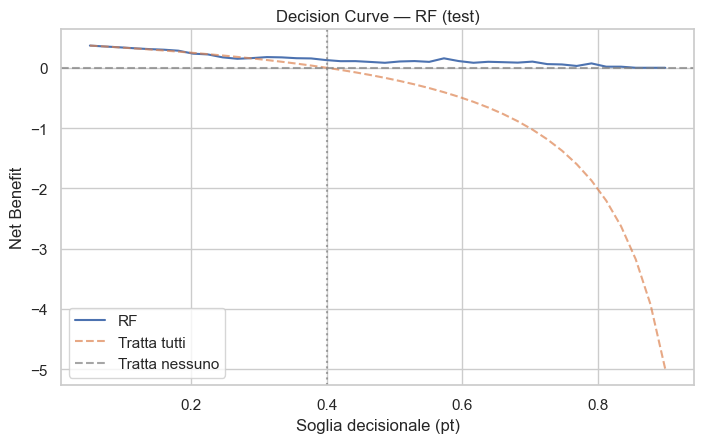

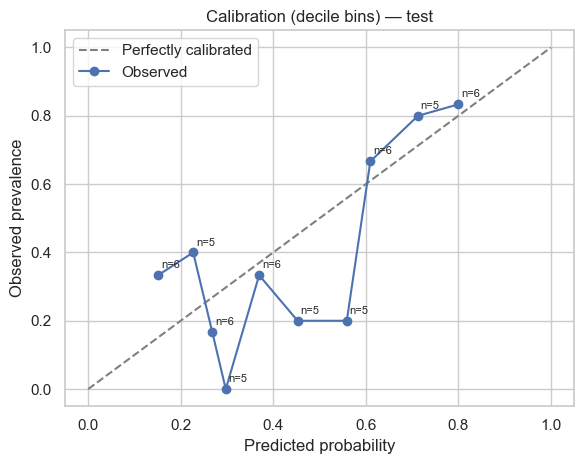

✔️  Figure salvate in: ../figures


In [44]:
# ========= STEP 10 — Figure semplici e pulite =========
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.inspection import partial_dependence
from sklearn.metrics import brier_score_loss
import shap, os

sns.set(style="whitegrid")
FIG_DIR = "../figures"; os.makedirs(FIG_DIR, exist_ok=True)

# --- Helper per gestire differenze di versione SHAP (sempre classe positiva) ----
def ensure_1d(a, n_expected=None, take_last_axis=True):
    a = np.asarray(a)
    if a.ndim == 0:
        a = a.reshape(1)
    if a.ndim == 2:
        # Es.: (n, 2) -> prendo la seconda colonna (classe 1)
        a = a[:, -1] if take_last_axis else a[:, 0]
    if (n_expected is not None) and (len(a) != n_expected):
        # in estrema difesa: taglio/pad
        a = a[:n_expected]
    return a

# --- SHAP explainer + proba su test (se mancano) ---
try:
    shap_expl
except NameError:
    explainer = shap.TreeExplainer(rf, data=X_train, feature_names=feature_order)
    shap_expl = explainer(X_test)

try:
    p_test
except NameError:
    p_test = rf.predict_proba(X_test)[:, 1]

n_test = len(X_test)

# =============== 10.1 SHAP-dependence (MSE ML, color=iHR V) ====================
feat_x = "MSE ML"
feat_c = "iHR V"

# x: valore della feature sul test
x_vals = X_test[feat_x].to_numpy()

# y: shap value della stessa feature (classe positiva)
# Per massima compatibilità uso sia lo slicing "nuovo" sia quello "vecchio"
try:
    y_vals = shap_expl[:, feat_x].values
except Exception:
    col = X_test.columns.get_loc(feat_x)
    y_vals = shap_expl.values[:, col]
y_vals = ensure_1d(y_vals, n_expected=n_test)

# colore: valore (raw) della feature di colore
try:
    c_vals = shap_expl[:, feat_c].data
except Exception:
    c_vals = X_test[feat_c].to_numpy()
c_vals = ensure_1d(c_vals, n_expected=n_test, take_last_axis=False)

plt.figure(figsize=(8, 4.2))
sc = plt.scatter(x_vals, y_vals, c=c_vals, s=38, cmap="magma", edgecolor="none")
plt.xlabel(feat_x); plt.ylabel(f"SHAP value for {feat_x}")
cb = plt.colorbar(sc); cb.set_label(feat_c)
plt.title(f"SHAP dependence — {feat_x} (color: {feat_c})")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/step10a_shap_dependence_{feat_x.replace(' ','_')}.png", dpi=300)
plt.show()

# ================== 10.2 PDP 2D (MSE ML × MSE V) ===============================
f1, f2 = "MSE ML", "MSE V"
i1, i2 = X_test.columns.get_loc(f1), X_test.columns.get_loc(f2)
pd2 = partial_dependence(rf, X_test, [(i1, i2)], grid_resolution=25,
                         kind="average", method="brute")

if isinstance(pd2, dict):   # sklearn >= 1.4
    surf = pd2["average"][0]
    g1, g2 = pd2["values"]
else:                        # sklearn <= 1.3
    surf = pd2.average[0]
    g1, g2 = pd2.grid_values

plt.figure(figsize=(7.2, 4.6))
sns.heatmap(surf, xticklabels=np.round(g2, 2), yticklabels=np.round(g1, 2),
            cmap="magma", cbar_kws={"label": "Partial dependence P(Triade)"})
plt.xlabel(f2); plt.ylabel(f1)
plt.title(f"PDP 2D — {f1} × {f2} (test)")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/step10b_pdp2d_{f1.replace(' ','_')}_x_{f2.replace(' ','_')}.png", dpi=300)
plt.show()

# ================== 10.3 Decision Curve Analysis (semplice) ====================
def decision_curve(y_true, p, pt_grid=None):
    if pt_grid is None:
        pt_grid = np.linspace(0.05, 0.9, 40)
    nb_model, nb_all = [], []
    Y = y_true.astype(int)
    for pt in pt_grid:
        pred = (p >= pt).astype(int)
        TP = np.sum((pred == 1) & (Y == 1))
        FP = np.sum((pred == 1) & (Y == 0))
        N  = len(Y)
        nb = (TP/N) - (FP/N) * (pt/(1-pt))
        nb_model.append(nb)
        # treat-all
        prev = Y.mean()
        nb_all.append(prev - (1 - prev) * (pt/(1-pt)))
    return pd.DataFrame({"pt": pt_grid, "NB_model": nb_model, "NB_all": nb_all})

dca = decision_curve(y_test, p_test)
plt.figure(figsize=(7.2, 4.6))
plt.plot(dca["pt"], dca["NB_model"], label="RF")
plt.plot(dca["pt"], dca["NB_all"], "--", label="Tratta tutti", alpha=0.7)
plt.axhline(0, ls="--", color="grey", label="Tratta nessuno", alpha=0.7)
plt.axvline(0.40, ls=":", color="grey", alpha=0.7)
plt.xlabel("Soglia decisionale (pt)"); plt.ylabel("Net Benefit")
plt.title("Decision Curve — RF (test)")
plt.legend()
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/step10c_decision_curve_rf.png", dpi=300)
plt.show()

# ================== 10.4 Calibration (decile plot) =============================
def calibration_by_decile(y_true, proba, bins=10):
    df = pd.DataFrame({"y": y_true, "p": proba}).sort_values("p")
    df["bin"] = pd.qcut(df["p"], q=bins, duplicates="drop")
    grp = df.groupby("bin", observed=False)
    out = grp.agg(
        pred=("p", "mean"),
        obs=("y", "mean"),
        n=("y", "size")
    ).reset_index(drop=True)
    return out

cal = calibration_by_decile(y_test, p_test, bins=10)
plt.figure(figsize=(6.0, 4.8))
plt.plot([0,1], [0,1], "--", color="grey", label="Perfectly calibrated")
plt.plot(cal["pred"], cal["obs"], "o-", label="Observed")
for i, n in enumerate(cal["n"]):
    plt.annotate(f"n={int(n)}", (cal["pred"][i], cal["obs"][i]),
                 textcoords="offset points", xytext=(2,5), fontsize=8)
plt.xlabel("Predicted probability"); plt.ylabel("Observed prevalence")
plt.title("Calibration (decile bins) — test")
plt.legend()
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/step10d_calibration_decile.png", dpi=300)
plt.show()

# (opzionale) report di salvataggio
print("✔️  Figure salvate in:", FIG_DIR)

Test metrics: {'ROC_AUC': 0.731404958677686, 'PR_AUC': 0.7330443035176697, 'Brier': 0.19826214334617953}

Metrics @ thresholds:
     thr  precision    recall        f1  specificity     brier
0  0.26   0.428571  0.818182  0.562500     0.272727  0.198262
1  0.40   0.555556  0.681818  0.612245     0.636364  0.198262
2  0.50   0.583333  0.636364  0.608696     0.696970  0.198262

Kendall τ (RF vs SHAP mean rank): 0.82


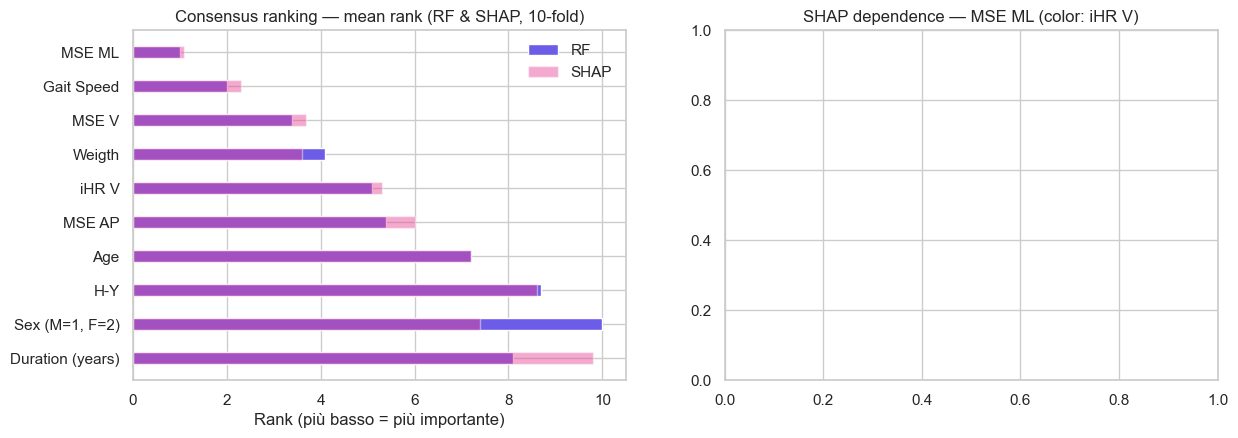

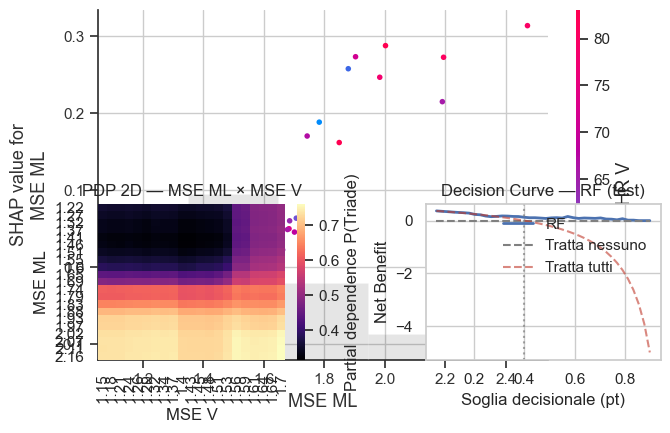

/var/folders/qp/ffk__r314v1g0597vzpyysdw0000gn/T/ipykernel_42489/544355641.py:203: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby("bin").agg(p_mean=("p","mean"), y_rate=("y","mean"), n=("y","size")).reset_index(drop=True)


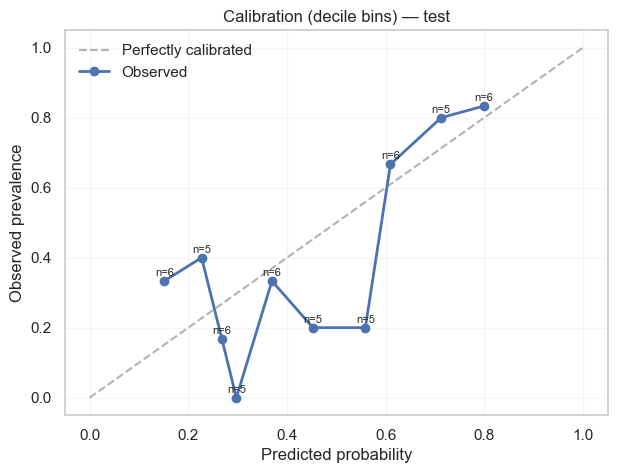

TypeError: Object of type int64 is not JSON serializable

In [ ]:
# =========================================
# STEP 10 — Synthesis & Paper-ready Assets
# =========================================
import os, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score, average_precision_score, brier_score_loss,
                             precision_recall_curve, roc_curve, precision_score,
                             recall_score, f1_score)
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import partial_dependence
from scipy.stats import kendalltau

import shap

# ---------- Paths
FIG_DIR = "../figurez/global"
OUT_DIR = "../tables"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- Data & features
train = pd.read_csv("../data/processed/train_balanced_ctgan.csv")
test  = pd.read_csv("../data/processed/test_original.csv")

feature_order = [
    "MSE ML","iHR V","MSE V","MSE AP","Weigth","Age",
    "Sex (M=1, F=2)","H-Y","Gait Speed","Duration (years)"
]
X_train = train[feature_order].copy()
y_train = train["target_bin"].astype(int).values
X_test  = test[feature_order].copy()
y_test  = test["target_bin"].astype(int).values

# ---------- Final RF (stesso setup usato negli step precedenti)
rf = RandomForestClassifier(
    n_estimators=800,
    min_samples_leaf=3,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
).fit(X_train, y_train)

p_test = rf.predict_proba(X_test)[:,1]

# ---------- Metriche globali + soglie cliniche
def metrics_global(y, p):
    return dict(
        ROC_AUC=float(roc_auc_score(y, p)),
        PR_AUC=float(average_precision_score(y, p)),
        Brier=float(brier_score_loss(y, p))
    )

def metrics_at_threshold(y, p, thr):
    pred = (p >= thr).astype(int)
    return dict(
        thr=float(thr),
        precision=float(precision_score(y, pred, zero_division=0)),
        recall=float(recall_score(y, pred, zero_division=0)),
        f1=float(f1_score(y, pred, zero_division=0)),
        specificity=float(((pred==0) & (y==0)).sum() / (y==0).sum()),
        brier=float(brier_score_loss(y, p))
    )

glob = metrics_global(y_test, p_test)
thr_tbl = pd.DataFrame([metrics_at_threshold(y_test, p_test, t) for t in [0.26, 0.40, 0.50]])
thr_tbl.to_csv(f"{OUT_DIR}/step10_threshold_metrics.csv", index=False)

print("Test metrics:", glob)
print("\nMetrics @ thresholds:\n", thr_tbl)

# ---------- Decision Curve Analysis (Net Benefit)
def decision_curve_net_benefit(y, p, pts=np.linspace(0.05,0.90,40)):
    y = np.asarray(y); p = np.asarray(p)
    N = len(y)
    out = []
    for pt in pts:
        pred = (p >= pt).astype(int)
        TP = np.sum((pred==1) & (y==1))
        FP = np.sum((pred==1) & (y==0))
        NB = (TP/N) - (FP/N) * (pt/(1-pt))
        # strategie baseline
        prev = y.mean()
        NB_all  = prev - (1-prev) * (pt/(1-pt))
        NB_none = 0.0
        out.append((pt, NB, NB_all, NB_none))
    return pd.DataFrame(out, columns=["pt","NB_model","NB_all","NB_none"])

dca = decision_curve_net_benefit(y_test, p_test)
dca.to_csv(f"{OUT_DIR}/step10_decision_curve.csv", index=False)

# ---------- SHAP (classe positiva) per plots di sintesi
expl = shap.TreeExplainer(rf, data=X_train, feature_names=feature_order)
sh_expl = expl(X_test)  # shap.Explanation
# se multi-output, seleziona classe 1
if hasattr(sh_expl.values, "ndim") and sh_expl.values.ndim == 3:
    vals = sh_expl.values[:,:,1]
    bases = sh_expl.base_values[:,1] if np.ndim(sh_expl.base_values)==2 else sh_expl.base_values
    shap_pos = shap.Explanation(values=vals, base_values=bases,
                                data=X_test.values, feature_names=feature_order)
else:
    shap_pos = sh_expl

# ---------- Consensus ranking (RF + SHAP) via 10-fold (veloce ma riproducibile)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
rf_ranks, shap_ranks = [], []

for tr, va in kf.split(X_train, y_train):
    Xtr, Xva = X_train.iloc[tr], X_train.iloc[va]
    ytr, yva = y_train[tr], y_train[va]
    clf = RandomForestClassifier(
        n_estimators=400, min_samples_leaf=3,
        class_weight="balanced", random_state=42, n_jobs=-1
    ).fit(Xtr, ytr)

    # RF rank
    rf_imp = pd.Series(clf.feature_importances_, index=feature_order)
    rf_ranks.append(rf_imp.rank(ascending=False, method="average"))

    # SHAP rank
    ex = shap.TreeExplainer(clf, data=Xtr, feature_names=feature_order)
    sv = ex(Xva).values
    if sv.ndim == 3: sv = sv[:,:,1]
    mabs = pd.Series(np.abs(sv).mean(axis=0), index=feature_order)
    shap_ranks.append(mabs.rank(ascending=False, method="average"))

rf_rank_df   = pd.DataFrame(rf_ranks,   columns=feature_order)
shap_rank_df = pd.DataFrame(shap_ranks, columns=feature_order)

rf_mean   = rf_rank_df.mean(0);   rf_sd   = rf_rank_df.std(0, ddof=1)
sh_mean   = shap_rank_df.mean(0); sh_sd   = shap_rank_df.std(0, ddof=1)

consensus = pd.DataFrame({
    "RF_mean_rank": rf_mean, "RF_sd": rf_sd,
    "SHAP_mean_rank": sh_mean, "SHAP_sd": sh_sd
})
consensus["Consensus_score"] = (consensus["RF_mean_rank"] + consensus["SHAP_mean_rank"])/20.0
consensus["Consensus_rank"]  = consensus["Consensus_score"].rank(method="min")
consensus["Stability_sd"]    = 0.5*(consensus["RF_sd"] + consensus["SHAP_sd"])
consensus = consensus.sort_values("Consensus_rank")
consensus.to_csv(f"{OUT_DIR}/step10_consensus_ranking.csv")

tau, _ = kendalltau(rf_mean, sh_mean)
print(f"\nKendall τ (RF vs SHAP mean rank): {tau:.2f}")

# ---------- PDP 2D (MSE ML × MSE V) per pannello
def pdp2d(model, X, a, b, grid=25):
    pa = partial_dependence(model, X, [(X.columns.get_loc(a), X.columns.get_loc(b))],
                            grid_resolution=grid, kind="average", method="brute")
    if isinstance(pa, dict):
        surf = pa["average"][0]; g1, g2 = pa["values"]
    else:
        surf = pa.average[0]; g1, g2 = pa.grid_values
    return g1, g2, surf

g1, g2, surf = pdp2d(rf, X_test, "MSE ML", "MSE V", grid=21)

# ---------- FIGURE OVERVIEW (4 pannelli)
plt.figure(figsize=(14,10))

# A) Consensus barh
ax1 = plt.subplot(2,2,1)
ord_idx = consensus.index
ax1.barh(ord_idx, consensus.loc[ord_idx,"RF_mean_rank"], height=0.35, label="RF", color="#6c5ce7")
ax1.barh(ord_idx, consensus.loc[ord_idx,"SHAP_mean_rank"], height=0.35, left=0, alpha=0.45, label="SHAP", color="#e84393")
ax1.invert_yaxis()
ax1.set_title("Consensus ranking — mean rank (RF & SHAP, 10-fold)")
ax1.set_xlabel("Rank (più basso = più importante)")
ax1.legend(frameon=False)

# B) SHAP dependence MSE ML (color: iHR V)
ax2 = plt.subplot(2,2,2)
shap.plots.scatter(shap_pos[:, "MSE ML"], color=shap_pos[:, "iHR V"], show=False)
ax2.set_title("SHAP dependence — MSE ML (color: iHR V)")

# C) PDP 2D heatmap
ax3 = plt.subplot(2,2,3)
sns.heatmap(surf, xticklabels=np.round(g2,2), yticklabels=np.round(g1,2),
            cmap="magma", cbar_kws={"label":"Partial dependence P(Triade)"}, ax=ax3)
ax3.set_xlabel("MSE V"); ax3.set_ylabel("MSE ML")
ax3.set_title("PDP 2D — MSE ML × MSE V")

# D) Decision Curve
ax4 = plt.subplot(2,2,4)
ax4.plot(dca["pt"], dca["NB_model"], label="RF", lw=2)
ax4.plot(dca["pt"], dca["NB_none"], "--", color="gray", label="Tratta nessuno")
ax4.plot(dca["pt"], dca["NB_all"],  "--", color="#c0392b", alpha=0.6, label="Tratta tutti")
ax4.axvline(0.40, ls=":", color="gray", alpha=0.7)
ax4.set_xlabel("Soglia decisionale (pt)"); ax4.set_ylabel("Net Benefit")
ax4.set_title("Decision Curve — RF (test)")
ax4.legend(frameon=False, loc="upper right")

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/step10_overview_panel.png", dpi=300)
plt.show()

# ---------- Calibration: reliability plot + histogram
def calibration_plot(y, p, nbins=10, fname=None):
    df = pd.DataFrame({"y":y, "p":p})
    df["bin"] = pd.qcut(df["p"], q=nbins, duplicates="drop")
    grp = df.groupby("bin").agg(p_mean=("p","mean"), y_rate=("y","mean"), n=("y","size")).reset_index(drop=True)
    plt.figure(figsize=(7,5))
    plt.plot([0,1],[0,1],"--",color="gray",alpha=0.6,label="Perfectly calibrated")
    plt.plot(grp["p_mean"], grp["y_rate"], marker="o", lw=2, label="Observed")
    for _,r in grp.iterrows():
        plt.text(r["p_mean"], r["y_rate"]+0.015, f"n={int(r['n'])}", ha="center", fontsize=8)
    plt.xlabel("Predicted probability"); plt.ylabel("Observed prevalence")
    plt.title("Calibration (decile bins) — test")
    plt.grid(alpha=0.2); plt.legend(frameon=False)
    if fname:
        plt.savefig(fname, dpi=300, bbox_inches="tight")
    plt.show()

calibration_plot(y_test, p_test, nbins=10, fname=f"{FIG_DIR}/step10_calibration.png")

# ---------- Model Card (paper-ready mini profile)
top5 = consensus.sort_values("Consensus_rank").head(5).index.tolist()
model_card = {
    "dataset": {
        "train_balanced_ctgan_shape": list(X_train.shape),
        "test_original_shape": list(X_test.shape),
        "test_target_dist": dict(pd.Series(y_test).value_counts().sort_index())
    },
    "model": "RandomForestClassifier (n_estimators=800, min_samples_leaf=3, class_weight='balanced')",
    "test_metrics": glob,
    "threshold_metrics": thr_tbl.to_dict(orient="records"),
    "consensus_top5_features": top5,
    "kendall_tau_RF_vs_SHAP": float(tau),
    "figures": {
        "overview_panel": f"{FIG_DIR}/step10_overview_panel.png",
        "calibration": f"{FIG_DIR}/step10_calibration.png"
    }
}
with open(f"{OUT_DIR}/step10_model_card.json","w") as f: json.dump(model_card, f, indent=2)

md = f"""# Model Card — Triade RF (Explainability Synthesis)

**Train/Test**: train_balanced_ctgan={X_train.shape}, test_original={X_test.shape}  
**Test metrics**: ROC_AUC={glob['ROC_AUC']:.3f}, PR_AUC={glob['PR_AUC']:.3f}, Brier={glob['Brier']:.3f}

**Threshold metrics** (test):
{thr_tbl.round(3).to_markdown(index=False)}

**Consensus Top-5 (RF+SHAP, 10-fold)**: {', '.join(top5)}

**RF vs SHAP rank concordance**: Kendall τ = {tau:.2f}

**Figures**:
- `step10_overview_panel.png` (consensus, SHAP dependence, PDP 2D, DCA)
- `step10_calibration.png` (reliability)
"""
with open(f"{OUT_DIR}/step10_model_card.md","w") as f: f.write(md)

print("✅ Saved:",
      f"\n- {FIG_DIR}/step10_overview_panel.png",
      f"\n- {FIG_DIR}/step10_calibration.png",
      f"\n- {OUT_DIR}/step10_model_card.json",
      f"\n- {OUT_DIR}/step10_model_card.md",
      f"\n- {OUT_DIR}/step10_consensus_ranking.csv",
      f"\n- {OUT_DIR}/step10_threshold_metrics.csv",
      f"\n- {OUT_DIR}/step10_decision_curve.csv",
)

# ---------- Patient-level report utility (1-liner + SHAP waterfall)
def make_patient_report(idx, thr=0.40, save_dir=FIG_DIR):
    """Crea un mini-report per un soggetto del test set."""
    assert 0 <= idx < len(X_test), "idx fuori range (test set)"
    proba = float(p_test[idx]); y = int(y_test[idx])
    pred = int(proba >= thr)
    # Waterfall SHAP (classe positiva)
    ex = shap_pos[idx]
    plt.figure(figsize=(7.2,5.2))
    shap.plots.waterfall(ex, max_display=12, show=False)
    title = f"Waterfall — id={idx} | y={y} | p={proba:.2f} | thr={thr} → pred={pred}"
    plt.title(title); plt.tight_layout()
    fn = f"{save_dir}/step10_local_waterfall_id{idx}.png"
    plt.savefig(fn, dpi=300); plt.show()
    # Riepilogo riga
    row = X_test.iloc[idx].to_dict()
    print("▶️  Patient report",
          f"\n id={idx}  y={y}  p={proba:.3f}  pred@{thr}={pred}",
          f"\n key features:", {k: round(row[k],3) for k in ['MSE ML','MSE V','iHR V','Gait Speed','Weigth']},
          f"\n file: {fn}"
         )
    return fn

# Esempio: genera un report per il soggetto con p più vicino alla soglia 0.40
closest_idx = int(np.argsort(np.abs(p_test - 0.40))[0])
_ = make_patient_report(closest_idx, thr=0.40)